<a href="https://colab.research.google.com/github/a-manri/alerce5b/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparación inicial Google Colab

Librerías necesarias. Reiniciar runtime tras instalación

In [ ]:
# pyarrow might be needed to read the data
# !python -m pip install Cython
# !python -m pip install -e git+https://git@github.com/alercebroker/turbo-fats#egg=turbofats
!python -m pip install -e git+https://git@github.com/alercebroker/mhps#egg=mhps
!python -m pip install -e git+https://git@github.com/alercebroker/P4J#egg=P4J
# !python -m pip install pyarrow
!python -m pip install -e git+https://git@github.com/alercebroker/lc_classifier#egg=lc_classifier

Obtaining mhps from git+https://****@github.com/alercebroker/mhps#egg=mhps
  Cloning https://****@github.com/alercebroker/mhps to ./src/mhps
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/alercebroker/mhps' /content/src/mhps
  Resolved https://****@github.com/alercebroker/mhps to commit 1c827b7d19a44ecbd54d79dd2cd786ed17c4ce91
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mhps (pyproject.toml) ... done
  Created wheel for mhps: filename=mhps-0.1.1-0.editable-cp310-cp310-linux_x86_64.whl size=2542 sha256=1a6f8280a57c50de882dc6fab38ef154535c3579b4eb78bc900870dd526e26c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-pobq9z9k/wheels/0b/bb/3f/e92188fc518f5a26899e9e6310ec8b9ad464e344e86ac3d404
Successfully built mhps
Obtaining P4J from git+https://****@github.com/alercebrok

Acceso a datasets y repo en github

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Proyecto_inteligencia/alerce5b
! git pull

Mounted at /content/drive
/content/drive/MyDrive/Proyecto_inteligencia/alerce5b
Updating edd51e5..0d8924c
error: Your local changes to the following files would be overwritten by merge:
	main.ipynb
Please commit your changes or stash them before you merge.
error: The following untracked working tree files would be overwritten by merge:
	data/preprocessed/features_with_labels.parquet
Please move or remove them before you merge.
Aborting


## Carga de datos desde el dataset alerceZTFv7.1

In [ ]:
import numpy as np
import pandas as pd

survey_name = 'alerceZTFv7.1' # use this dataset
### load files
load_root_dir = f'./data/{survey_name}'

detections_df = pd.read_parquet(f'{load_root_dir}/curvas_ztf_2023.parquet')
print(f'detections_df; columns={list(detections_df.columns)}; id={detections_df.index.name}')

labels_df = detections_df.drop(['band','time','magnitude','error'],axis=1).reset_index().drop_duplicates(subset='oid').set_index('oid')
print(f'labels_df; columns={list(labels_df.columns)}; id={labels_df.index.name}')

detections_df = detections_df.drop(['classALeRCE'],axis=1)

### print info
classes = sorted(set(labels_df['classALeRCE'].values))
print(f'classes={classes}')

detections_df; columns=['band', 'time', 'magnitude', 'error', 'classALeRCE']; id=oid
labels_df; columns=['classALeRCE']; id=oid
classes=['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL']


In [ ]:
detections_df

,band,time,magnitude,error
oid,,,,
ZTF17aaaabpo,1,58867.199491,17.608220,0.030901
ZTF17aaaabpo,1,59463.455949,17.559150,0.023797
ZTF17aaaabpo,1,58867.201794,17.577080,0.029173
ZTF17aaaabpo,2,58805.390787,16.956377,0.016151
ZTF17aaaabpo,1,58796.291655,17.652918,0.054965
...,...,...,...,...
ZTF20abgmmcg,2,60082.324456,16.640200,0.108121
ZTF20abgmmcg,1,60118.232894,16.397900,0.063889
ZTF20abgmmcg,2,59266.523391,16.130400,0.035867


In [ ]:
labels_df

,classALeRCE
oid,
ZTF17aaaabpo,EB/EW
ZTF17aaaabrg,EB/EW
ZTF17aaaabrl,EB/EW
ZTF17aaaabte,EB/EW
ZTF17aaaacfh,EB/EW
...,...
ZTF20abaokun,LPV
ZTF20abbuhco,RRL
ZTF20abdntwb,RRL


Número de estellas periódicas en las detecciones

In [ ]:
detections_df.index.nunique()

81626

#### Visualización del desbalance de clases

In [ ]:
# count the number of elements in each class and round to 2 decimal digits
rounded_counts = round(labels_df['classALeRCE'].value_counts(normalize=True,)*100, 2)
print('Porcentaje de elementos de cada clase:')
print(rounded_counts)

Porcentaje de elementos de cada clase:
RRL      42.05
EB/EW    39.84
LPV      16.33
DSCT      0.98
Ceph      0.81
Name: classALeRCE, dtype: float64


## Extracción de features

### Todos los extractores de lc_classifier

In [ ]:
from lc_classifier.features import FeatureExtractorComposer # Permite componer (concatenar) extractores en un solo objeto

# Extractores usados en este trabajo
from lc_classifier.features import TurboFatsFeatureExtractor
from lc_classifier.features import GPDRWExtractor
from lc_classifier.features import PeriodExtractor
from lc_classifier.features import WiseStaticExtractor
from lc_classifier.features import ZTFColorForcedFeatureExtractor
from lc_classifier.features import MHPSExtractor
from lc_classifier.features import FoldedKimExtractor # necesita usarse en un FeatureExtractorComposer junto a otros extractores
from lc_classifier.features import HarmonicsExtractor # necesita usarse en un FeatureExtractorComposer junto a otros extractores
from lc_classifier.features import IQRExtractor
from lc_classifier.features import PowerRateExtractor # necesita usarse en un FeatureExtractorComposer junto a otros extractores

# Extractores no usados en este trabajo
from lc_classifier.features import ZTFColorFeatureExtractor
from lc_classifier.features import ElasticcColorFeatureExtractor
from lc_classifier.features import GalacticCoordinatesExtractor
from lc_classifier.features import MHPSFluxExtractor
from lc_classifier.features import RealBogusExtractor
from lc_classifier.features import SGScoreExtractor
from lc_classifier.features import StreamSGScoreExtractor
from lc_classifier.features import SupernovaeDetectionFeatureExtractor
from lc_classifier.features import SupernovaeDetectionAndNonDetectionFeatureExtractor
from lc_classifier.features import SNParametricModelExtractor
from lc_classifier.features import WiseStreamExtractor
from lc_classifier.features import SNFeaturesPhaseIIExtractor
from lc_classifier.features import SPMExtractorPhaseII
from lc_classifier.features import ElasticcMetadataExtractor
from lc_classifier.features import ElasticcFullMetadataExtractor
from lc_classifier.features import TimespanExtractor
from lc_classifier.features import ZTFFeatureExtractor
from lc_classifier.features import ZTFForcedPhotometryFeatureExtractor
from lc_classifier.features import ElasticcFeatureExtractor

In [ ]:
# feature extractor parameters
bands = [1, 2] # 1=g, 2=r
true_period = 0.37
smallest_period = 0.05
largest_period = 500
optimal_grid = False
trim_lightcurve_to_n_days = 3000
min_length = 5

In [ ]:
# extractor para todas las features a usar en este trabajo
extractor = FeatureExtractorComposer(
    [
        TurboFatsFeatureExtractor(bands),
        GPDRWExtractor(bands),
        PeriodExtractor(bands,smallest_period,largest_period,optimal_grid,trim_lightcurve_to_n_days,min_length),
        WiseStaticExtractor(),
        ZTFColorForcedFeatureExtractor(),
        MHPSExtractor(bands),
        FoldedKimExtractor(bands),
        HarmonicsExtractor(bands),
        IQRExtractor(bands),
        PowerRateExtractor(bands)
    ]
)

### Testeo de extractores en una muestra acotada de detecciones

In [ ]:
# subset de las detecciones para probar los extractores
sub_detections_df = detections_df[:1000]

In [ ]:
import time
start_time = time.time()

feature_extractorrrr = ZTFColorForcedFeatureExtractor()
features = feature_extractorrrr.compute_features(sub_detections_df)

end_time = time.time()

features.columns.tolist()

In [ ]:
import time
start_time = time.time()

features = extractor.compute_features(sub_detections_df)

end_time = time.time()

features_cols = features.columns.tolist()
print('Features extraídas:', features_cols)
print('N° de features extraídas:', len(features_cols))
print('Tiempo transcurrido:', round(end_time - start_time,2), 'segundos')

Features extraídas: ['Amplitude_1', 'AndersonDarling_1', 'Autocor_length_1', 'Beyond1Std_1', 'Con_1', 'Eta_e_1', 'Gskew_1', 'MaxSlope_1', 'Mean_1', 'Meanvariance_1', 'MedianAbsDev_1', 'MedianBRP_1', 'PairSlopeTrend_1', 'PercentAmplitude_1', 'Q31_1', 'Rcs_1', 'Skew_1', 'SmallKurtosis_1', 'Std_1', 'StetsonK_1', 'Pvar_1', 'ExcessVar_1', 'SF_ML_amplitude_1', 'SF_ML_gamma_1', 'IAR_phi_1', 'LinearTrend_1', 'Amplitude_2', 'AndersonDarling_2', 'Autocor_length_2', 'Beyond1Std_2', 'Con_2', 'Eta_e_2', 'Gskew_2', 'MaxSlope_2', 'Mean_2', 'Meanvariance_2', 'MedianAbsDev_2', 'MedianBRP_2', 'PairSlopeTrend_2', 'PercentAmplitude_2', 'Q31_2', 'Rcs_2', 'Skew_2', 'SmallKurtosis_2', 'Std_2', 'StetsonK_2', 'Pvar_2', 'ExcessVar_2', 'SF_ML_amplitude_2', 'SF_ML_gamma_2', 'IAR_phi_2', 'LinearTrend_2', 'GP_DRW_sigma_1', 'GP_DRW_tau_1', 'GP_DRW_sigma_2', 'GP_DRW_tau_2', 'Multiband_period', 'PPE', 'Period_band_1', 'delta_period_1', 'Period_band_2', 'delta_period_2', 'W1-W2', 'W2-W3', 'g-W2', 'g-W3', 'r-W2', 'r-W3'

### Partición del dataframe de detecciones para la extracción de features evitando problemas de memoria

In [ ]:
classes = detections_df.index.unique()

sub_dataframes = []
sub_dataframes_length = 500000 # Largo aproximado de cada sub-dataframe

ranges = np.arange(sub_dataframes_length, len(detections_df), sub_dataframes_length)
ranges = np.append(ranges, len(detections_df))

k_temp = 0

for k in ranges:
    if k == len(detections_df):
        sub_dataframes.append(detections_df[k_temp:k])
    else:
        oid_temp = detections_df[k:k+1].index[0]
        k_temp_0 = k_temp
        k_temp = k+1
        while oid_temp == detections_df[k_temp:k_temp+1].index[0]:
            k_temp += 1
        sub_dataframes.append(detections_df[k_temp_0:k_temp])

len(sub_dataframes) # Cantidad de sub-dataframes

45

### Extracción de features

In [ ]:
import os
import gc

n = 0
for sub_df in sub_dataframes:
  features = extractor.compute_features(sub_df)
  filename = os.path.join('data/feature_partsv4',f"sub_dataframe_{n}.parquet")
  features.to_parquet(filename)
  n += 1
  gc.collect()

Unión de dataframes con features extraídas

In [ ]:
import glob
import os
import pandas as pd

path = 'data/feature_partsv4'
all_files = glob.glob(os.path.join(path, "*.parquet"))
df_from_each_file = (pd.read_parquet(f) for f in all_files)
features_df = pd.concat(df_from_each_file, ignore_index=False)

### Imputación de valores inválidos

Se cuenta el número de NaN y valores mayores a 1e16, estos valores serán reemplazados por -999 para asegurar el buen entrenamiento del clasificador

In [ ]:
# Los valores NaN son valores inválidos y los valores mayores a 1e16 son considerados como infinito, es decir, un valor inválido
print('El dataset contiene', features_df.isna().sum().sum(), 'valores NaN, y',
      (features_df > 1e16).sum().sum(), 'valores mayores o iguales a 1e16')


El dataset contiene 730422 valores NaN, y 0 valores mayores o iguales a 1e16


In [ ]:
from sklearn.impute import SimpleImputer

# Imputación de NaN
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999)
imp.fit(features_df)
features_df = pd.DataFrame(imp.transform(features_df), columns=features_df.columns, index=features_df.index)

# Reemplazo de valores sobre 1e16
features_df = features_df.where(features_df <= 1e16, -999)

display(features_df)

# guardar dataframe
features_df.to_parquet('data/alerceZTFv7.1/features_recalcv4.parquet')

,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Mean_1,Meanvariance_1,...,Harmonics_mse_2,Harmonics_chi_2,iqr_1,iqr_2,Power_rate_1/4,Power_rate_1/3,Power_rate_1/2,Power_rate_2,Power_rate_3,Power_rate_4
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aaxrruh,0.604489,1.000000,1.0,0.587629,0.000000,2.440130,-0.930321,0.601769,15.936257,0.024421,...,1.975183e-02,0.001025,0.651869,0.292997,0.010427,0.008148,0.090807,0.011554,0.007152,0.007471
ZTF19aaxrruk,1.402259,1.000000,1.0,0.446602,0.000000,2.471628,-1.280523,1.264868,17.364635,0.049391,...,8.658167e-02,0.003926,1.108605,0.988046,0.020361,0.014005,0.062105,0.001889,0.011901,0.020259
ZTF19aaxrrvw,0.988743,0.999955,8.0,0.310811,0.000000,0.028492,0.478325,0.083526,15.243942,0.038912,...,6.307721e-02,0.003335,0.921264,0.925077,0.099958,0.103790,0.217986,0.063003,0.020851,0.078469
ZTF19aaxrrwb,0.453626,1.000000,1.0,0.489583,0.000000,2.691876,-0.556377,0.375965,16.897580,0.017967,...,4.725858e-04,0.000025,0.536783,0.185264,0.037296,0.033510,0.010143,0.002704,0.005769,0.002936
ZTF19aaxrrwc,0.521933,1.000000,1.0,0.355556,0.000000,1.471598,-0.740637,0.539080,16.411122,0.021855,...,3.647632e-03,0.000172,0.664008,0.190739,0.024810,0.076576,0.072138,0.018696,0.003493,0.031819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20abdklmf,0.199657,1.000000,1.0,0.300000,0.000000,0.211976,-0.176942,3.802419,15.325947,0.007476,...,8.456186e-05,0.000054,0.043207,0.067432,0.019956,0.019956,0.021427,0.015712,0.005831,0.006354
ZTF20abdvqmc,0.228541,1.000000,1.0,0.351648,0.000000,0.046311,0.180774,0.310547,13.817310,0.012378,...,2.029218e-04,0.000011,0.353831,0.274079,0.009945,0.009945,0.009945,0.002181,0.006016,0.008885
ZTF20aberetd,0.705893,0.999206,1.0,0.210526,0.000000,0.781539,0.574586,0.173373,14.795001,0.020258,...,4.599260e-26,-999.000000,0.225600,0.260102,0.155202,0.193543,0.226977,0.110347,0.289359,0.419250


### Unión de features y clases

In [ ]:
import pandas as pd

features_df = pd.read_parquet('data/alerceZTFv7.1/trimmed_features_5.parquet') # dataset de features
labels_df = pd.read_parquet('data/alerceZTFv7.1/labels_vs.parquet') # dataset de labels
labels_df.index = labels_df.index.map(lambda x: str(x) + '5') # se agrega el número de detecciones cortadas para fácil identificación visual

merged_data = pd.merge(features_df, labels_df.loc[:, ['classALeRCE']], on='oid') # merge features y labels según oid
merged_data.to_parquet('data/preprocessed/features_recalcv4_labeled.parquet') # guardar features con labels
merged_data.head()

,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Mean_1,Meanvariance_1,...,Harmonics_chi_2,iqr_1,iqr_2,Power_rate_1/4,Power_rate_1/3,Power_rate_1/2,Power_rate_2,Power_rate_3,Power_rate_4,classALeRCE
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aaxrruh,0.604489,1.000000,1.0,0.587629,0.0,2.440130,-0.930321,0.601769,15.936257,0.024421,...,0.001025,0.651869,0.292997,0.010427,0.008148,0.090807,0.011554,0.007152,0.007471,RRL
ZTF19aaxrruk,1.402259,1.000000,1.0,0.446602,0.0,2.471628,-1.280523,1.264868,17.364635,0.049391,...,0.003926,1.108605,0.988046,0.020361,0.014005,0.062105,0.001889,0.011901,0.020259,RRL
ZTF19aaxrrvw,0.988743,0.999955,8.0,0.310811,0.0,0.028492,0.478325,0.083526,15.243942,0.038912,...,0.003335,0.921264,0.925077,0.099958,0.103790,0.217986,0.063003,0.020851,0.078469,LPV
ZTF19aaxrrwb,0.453626,1.000000,1.0,0.489583,0.0,2.691876,-0.556377,0.375965,16.897580,0.017967,...,0.000025,0.536783,0.185264,0.037296,0.033510,0.010143,0.002704,0.005769,0.002936,RRL
ZTF19aaxrrwc,0.521933,1.000000,1.0,0.355556,0.0,1.471598,-0.740637,0.539080,16.411122,0.021855,...,0.000172,0.664008,0.190739,0.024810,0.076576,0.072138,0.018696,0.003493,0.031819,RRL


# Busqueda de los mejores parametros

## GridSearchCV

In [ ]:
# balanced random forest with hyperparameter tuning
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Load data into a Pandas dataframe
df = pd.read_parquet('data/preprocessed/features_recalcv4_labeled.parquet')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('classALeRCE', axis=1), df['classALeRCE'], test_size=0.2)

max_depth = [10, 20, 30]
max_depth.append(None)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': max_depth,
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create a random forest classifier with balanced subsampling
brf = BalancedRandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(brf, param_grid, cv=5, n_jobs = -1, scoring='balanced_accuracy') # balanced_accuracy == macro recall

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


Se demora casi 2 horas. Los resultados obtenidos son los parámetros: max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300

# Random Forests

### Random Forest

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Load data into a Pandas dataframe
df = pd.read_parquet('data/preprocessed/features_recalcv4_labeled.parquet')
# df = pd.read_parquet('data/preprocessed/features_with_labels.parquet') # Features calculadas en este trabajo
# df = pd.read_parquet('data/preprocessed/data_original_features_labeled.parquet') # Features calculadas en el trabajo original
# df = data_original_filtered # Features calculadas en el trabajo original, filtradas para coincidir con las de este trabajo
# df = common_old_features.drop('oid', axis=1) # Features calculadas en este trabajo, solo para las estrellas también presentes en el dataframe del trabajo original

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('classALeRCE', axis=1), df['classALeRCE'], test_size=0.2)

# Create a random forest classifier
rf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Macro metrics
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Ceph       0.91      0.25      0.39       122
        DSCT       0.94      0.43      0.59       144
       EB/EW       0.93      0.95      0.94      6555
         LPV       1.00      0.99      0.99      2713
         RRL       0.94      0.95      0.95      6792

    accuracy                           0.95     16326
   macro avg       0.94      0.71      0.77     16326
weighted avg       0.95      0.95      0.95     16326



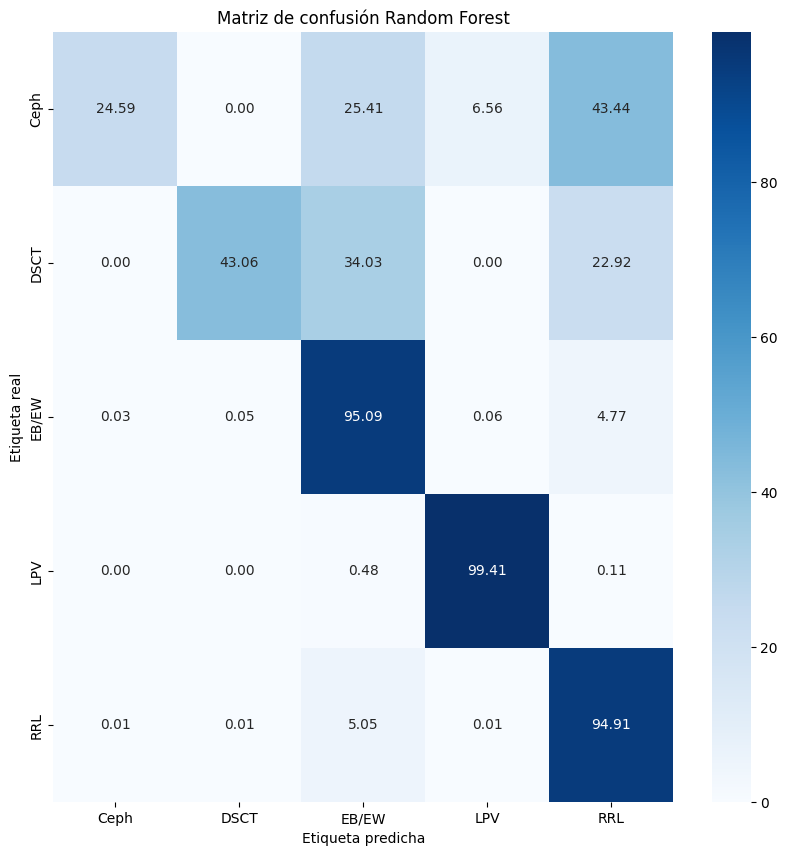

In [ ]:
# confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # correct order

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] *100
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de confusión Random Forest')
plt.show()

### Balanced Random Forest

In [ ]:
# balanced random forest
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Create a random forest classifier with 100 trees
brf = BalancedRandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300)

# Fit the model to the training data
brf.fit(X_train, y_train)

# Macro metrics
y_pred = brf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Ceph       0.14      0.83      0.23       122
        DSCT       0.14      0.86      0.24       144
       EB/EW       0.94      0.85      0.89      6555
         LPV       0.98      0.98      0.98      2713
         RRL       0.94      0.85      0.90      6792

    accuracy                           0.87     16326
   macro avg       0.63      0.87      0.65     16326
weighted avg       0.94      0.87      0.90     16326



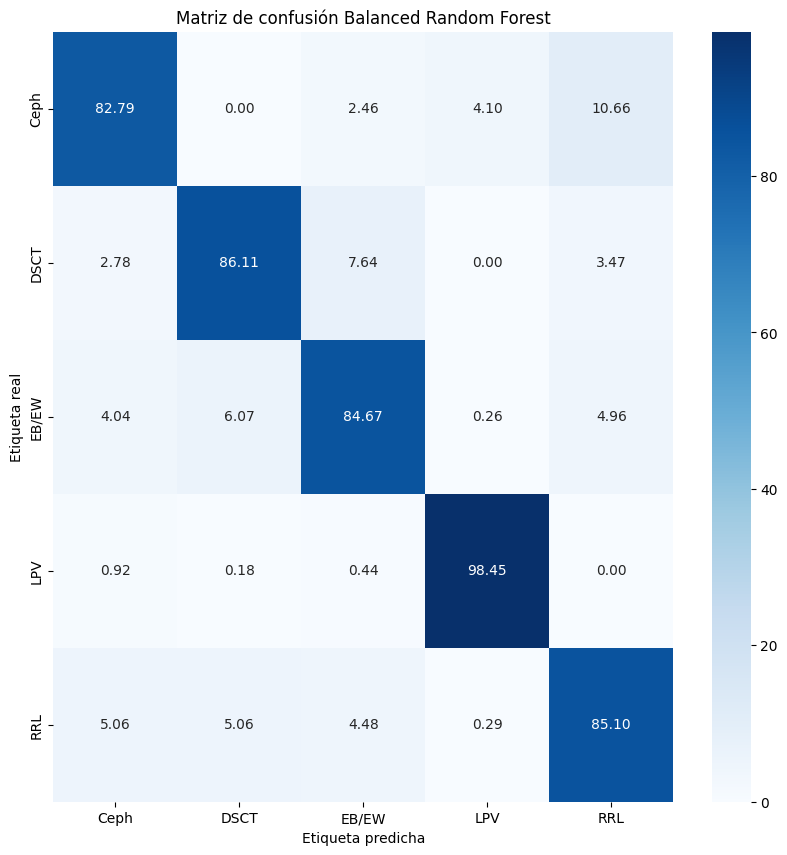

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # correct order

y_pred = brf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de confusión Balanced Random Forest')
plt.show()


## Usando k-folds cross-validation

### Random Forest k-folds

TRAIN: [    1     3     4 ... 81623 81624 81625] TEST: [    0     2     8 ... 81616 81618 81622]
TRAIN: [    0     1     2 ... 81622 81623 81625] TEST: [    6    14    21 ... 81610 81611 81624]
TRAIN: [    0     1     2 ... 81622 81623 81624] TEST: [    4     5    10 ... 81617 81620 81625]
TRAIN: [    0     2     4 ... 81623 81624 81625] TEST: [    1     3    12 ... 81604 81614 81619]
TRAIN: [    0     1     2 ... 81622 81624 81625] TEST: [    7     9    13 ... 81615 81621 81623]


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.95 ± 0.04,0.97 ± 0.01,0.93 ± 0.0,0.99 ± 0.0,0.94 ± 0.0,0.95 ± 0.0,0.96 ± 0.01
recall,0.29 ± 0.04,0.43 ± 0.04,0.95 ± 0.0,0.99 ± 0.0,0.95 ± 0.0,0.95 ± 0.0,0.72 ± 0.01
f1-score,0.44 ± 0.04,0.6 ± 0.04,0.94 ± 0.0,0.99 ± 0.0,0.95 ± 0.0,0.95 ± 0.0,0.78 ± 0.02
support,132.8 ± 12.35,159.4 ± 11.74,6503.4 ± 48.87,2665.2 ± 51.93,6864.4 ± 79.34,0.95 ± 0.0,16325.2 ± 0.4


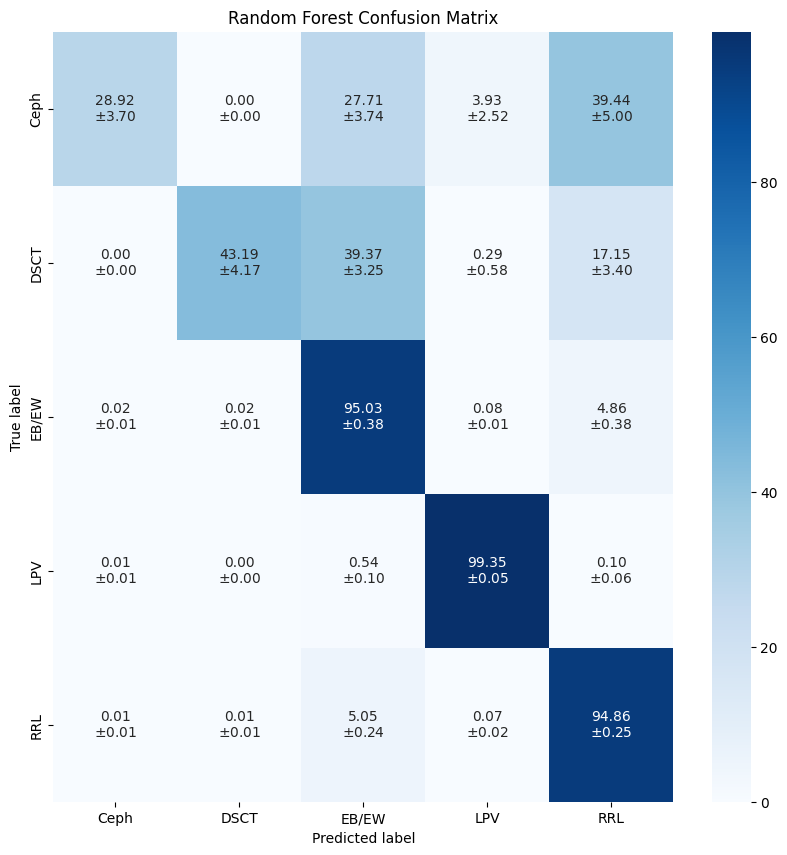

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter(action='ignore') # Limpiar el output de los FutureWarning de sklearn

# Cargar datos
df = pd.read_parquet('data/preprocessed/features_recalcv4_labeled.parquet') # Features recalculados_v4 a partir de las curvas originales (FINAL!)
# df = pd.read_parquet('data/preprocessed/trimmed_features_5_labeled.parquet')

class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # lista de clases

kf = KFold(n_splits=5, shuffle=True) # usar 5 folds (20% validación)

cm_list = [] # inicialización lista con matrices de confusión para cada fold
metrics_list = [] # inicialización lista con macro-métricas para cada fold

for train_index, test_index in kf.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df.drop('classALeRCE', axis=1).iloc[train_index], df.drop('classALeRCE', axis=1).iloc[test_index]
    y_train, y_test = df['classALeRCE'].iloc[train_index], df['classALeRCE'].iloc[test_index]
    rf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    class_report = classification_report(y_test, y_pred, output_dict=True)
    metrics_list.append(class_report) # lista con macro-métricas para cada fold

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    cm_list.append(cm) # lista con matrices de confusión para cada fold

# cálculo promedio de las macro-métricas en los k-folds
mean_metrics = pd.DataFrame(metrics_list[0])
for metricas in metrics_list[1:]:
    mean_metrics += pd.DataFrame(metricas)
mean_metrics = mean_metrics/len(metrics_list)

# cálculo desviación estándar de las macro-métricas en los k-folds
std_metrics = (pd.DataFrame(metrics_list[0])-mean_metrics).pow(2)
for metricas in metrics_list[1:]:
    std_metrics += (pd.DataFrame(metricas)-mean_metrics).pow(2)
std_metrics = (std_metrics/len(metrics_list)).pow(0.5)

# df con los valores promedio ± desviación estándar para las macro-métricas en los k-folds
report = mean_metrics.round(2).astype(str) + ' ± ' + std_metrics.round(2).astype(str)
report = report.drop('weighted avg', axis=1)
display(report)

# Matriz de confusión con promedio y desviación estándar de los k-folds
cm_list = np.array(cm_list)
cm_list.shape

cm_mean = np.mean(cm_list, axis=0)
cm_std = np.std(cm_list, axis=0)

text = []
thresh = cm_mean.max() / 2.
for i in range(cm_mean.shape[0]):
    for j in range(cm_mean.shape[1]):
        text.append('{0:.2f}'.format(cm_mean[i, j]) + '\n$\pm$' + '{0:.2f}'.format(cm_std[i, j]))

text = np.asarray(text).reshape(cm_mean.shape[0], cm_mean.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cm_mean, annot=text, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Random Forest Confusion Matrix')
plt.show()

### Balanced Random Forest k-folds

TRAIN: [    0     1     4 ... 81623 81624 81625] TEST: [    2     3     8 ... 81611 81615 81616]
TRAIN: [    0     1     2 ... 81620 81622 81623] TEST: [   16    19    22 ... 81621 81624 81625]
TRAIN: [    1     2     3 ... 81623 81624 81625] TEST: [    0     5     7 ... 81607 81613 81620]
TRAIN: [    0     1     2 ... 81623 81624 81625] TEST: [    4    10    11 ... 81603 81604 81622]
TRAIN: [    0     2     3 ... 81622 81624 81625] TEST: [    1     6    18 ... 81618 81619 81623]


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.15 ± 0.01,0.17 ± 0.01,0.94 ± 0.0,0.98 ± 0.0,0.94 ± 0.0,0.87 ± 0.0,0.64 ± 0.0
recall,0.84 ± 0.03,0.88 ± 0.01,0.85 ± 0.01,0.99 ± 0.0,0.85 ± 0.0,0.87 ± 0.0,0.88 ± 0.01
f1-score,0.25 ± 0.02,0.28 ± 0.01,0.89 ± 0.0,0.98 ± 0.0,0.9 ± 0.0,0.87 ± 0.0,0.66 ± 0.0
support,132.8 ± 9.06,159.4 ± 8.36,6503.4 ± 76.69,2665.2 ± 54.93,6864.4 ± 63.87,0.87 ± 0.0,16325.2 ± 0.4


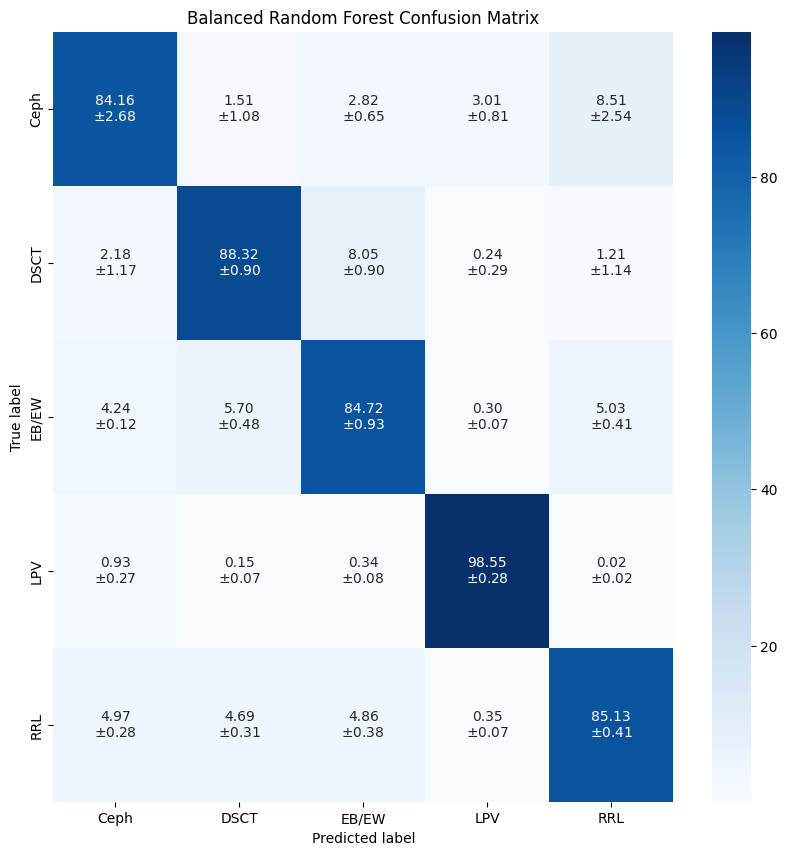

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter(action='ignore') # Limpiar el output de los FutureWarning de sklearn

# Cargar datos
df = pd.read_parquet('data/preprocessed/features_recalcv4_labeled.parquet') # Features recalculados_v4 a partir de las curvas originales (FINAL!)
# df = pd.read_parquet('data/preprocessed/trimmed_features_5_labeled.parquet')

class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # lista de clases

kf = KFold(n_splits=5, shuffle=True) # usar 5 folds (20% validación)

cm_list = [] # inicialización lista con matrices de confusión para cada fold
metrics_list = [] # inicialización lista con macro-métricas para cada fold

for train_index, test_index in kf.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df.drop('classALeRCE', axis=1).iloc[train_index], df.drop('classALeRCE', axis=1).iloc[test_index]
    y_train, y_test = df['classALeRCE'].iloc[train_index], df['classALeRCE'].iloc[test_index]
    brf = BalancedRandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300)
    brf.fit(X_train, y_train)
    y_pred = brf.predict(X_test)

    class_report = classification_report(y_test, y_pred, output_dict=True)
    metrics_list.append(class_report) # lista con macro-métricas para cada fold

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    cm_list.append(cm) # lista con matrices de confusión para cada fold

# cálculo promedio de las macro-métricas en los k-folds
mean_metrics = pd.DataFrame(metrics_list[0])
for metricas in metrics_list[1:]:
    mean_metrics += pd.DataFrame(metricas)
mean_metrics = mean_metrics/len(metrics_list)

# cálculo desviación estándar de las macro-métricas en los k-folds
std_metrics = (pd.DataFrame(metrics_list[0])-mean_metrics).pow(2)
for metricas in metrics_list[1:]:
    std_metrics += (pd.DataFrame(metricas)-mean_metrics).pow(2)
std_metrics = (std_metrics/len(metrics_list)).pow(0.5)

# df con los valores promedio ± desviación estándar para las macro-métricas en los k-folds
report = mean_metrics.round(2).astype(str) + ' ± ' + std_metrics.round(2).astype(str)
report = report.drop('weighted avg', axis=1)
display(report)

# Matriz de confusión con promedio y desviación estándar de los k-folds
cm_list = np.array(cm_list)
cm_list.shape

cm_mean = np.mean(cm_list, axis=0)
cm_std = np.std(cm_list, axis=0)

text = []
thresh = cm_mean.max() / 2.
for i in range(cm_mean.shape[0]):
    for j in range(cm_mean.shape[1]):
        text.append('{0:.2f}'.format(cm_mean[i, j]) + '\n$\pm$' + '{0:.2f}'.format(cm_std[i, j]))

text = np.asarray(text).reshape(cm_mean.shape[0], cm_mean.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cm_mean, annot=text, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Balanced Random Forest Confusion Matrix')
plt.show()

# Detección temprana

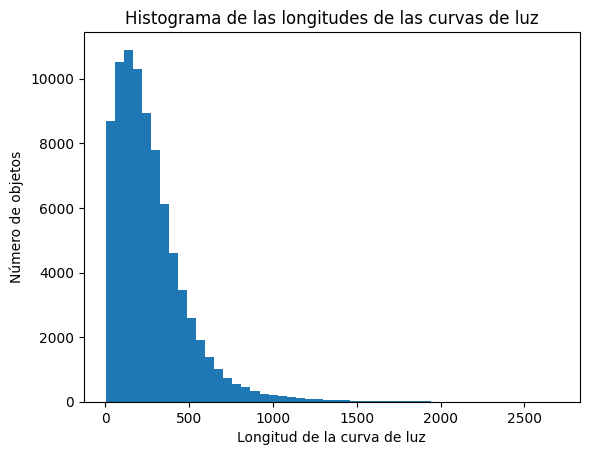

In [ ]:
import matplotlib.pyplot as plt

curve_lengths = detections_df.groupby('oid').size()

# Crear un histograma de las longitudes de las curvas de luz
plt.hist(curve_lengths, bins=50)
plt.xlabel('Longitud de la curva de luz')
plt.ylabel('Número de objetos')
plt.title('Histograma de las longitudes de las curvas de luz')
plt.show()

In [ ]:
print(max(curve_lengths),min(curve_lengths))

2695 6


## Clasificación de curvas cortas

### Corte de curvas y extracción de features

In [ ]:
# sort de las detecciones por oid y tiempo
sorted_df = detections_df.sort_values(by=['oid', 'time'])

# trim de las curvas de luz en n elementos máximo
n = 1000
sorted_df_1000 = sorted_df.groupby('oid').head(n)
sorted_df_1000.index = sorted_df_1000.index.map(lambda x: str(x) + '1000')
sorted_df_1000

In [ ]:
# subdivisión del df en segmentos de menor tamaño para extraer las features sin
# problemas de memoria
classes = sorted_df_1000.index.unique()

sub_dataframes = []
sub_dataframes_length = 500000 # largo aproximado de cada segmento

ranges = np.arange(sub_dataframes_length, len(detections_df), sub_dataframes_length)
ranges = np.append(ranges, len(detections_df))

k_temp = 0

for k in ranges:
    if k == len(detections_df):
        sub_dataframes.append(detections_df[k_temp:k])
    else:
        oid_temp = detections_df[k:k+1].index[0]
        k_temp_0 = k_temp
        k_temp = k+1
        while oid_temp == detections_df[k_temp:k_temp+1].index[0]:
            k_temp += 1
        sub_dataframes.append(detections_df[k_temp_0:k_temp])

len(sub_dataframes)

In [ ]:
# extracción de features de los segmentos del df
import os
import gc

n = 0
for sub_df in sub_dataframes:
  features = extractor.compute_features(sub_df)
  filename = os.path.join('data/trimmed_feature_parts',f"sub_dataframe_{n}.parquet")
  features.to_parquet(filename)
  n += 1
  gc.collect()

### Balanced Random Forest con k-folds para los distintos largos máximos de curvas de luz

BRF entrenado usando curvas de máximo 5 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.03 ± 0.0,0.02 ± 0.0,0.66 ± 0.01,0.72 ± 0.01,0.68 ± 0.01,0.46 ± 0.01,0.42 ± 0.0
recall,0.52 ± 0.05,0.45 ± 0.04,0.48 ± 0.01,0.87 ± 0.0,0.29 ± 0.02,0.46 ± 0.01,0.52 ± 0.01
f1-score,0.05 ± 0.01,0.05 ± 0.0,0.55 ± 0.01,0.79 ± 0.01,0.41 ± 0.02,0.46 ± 0.01,0.37 ± 0.0
support,132.8 ± 13.83,159.4 ± 8.01,6503.4 ± 81.82,2665.2 ± 27.61,6864.4 ± 62.72,0.46 ± 0.01,16325.2 ± 0.4


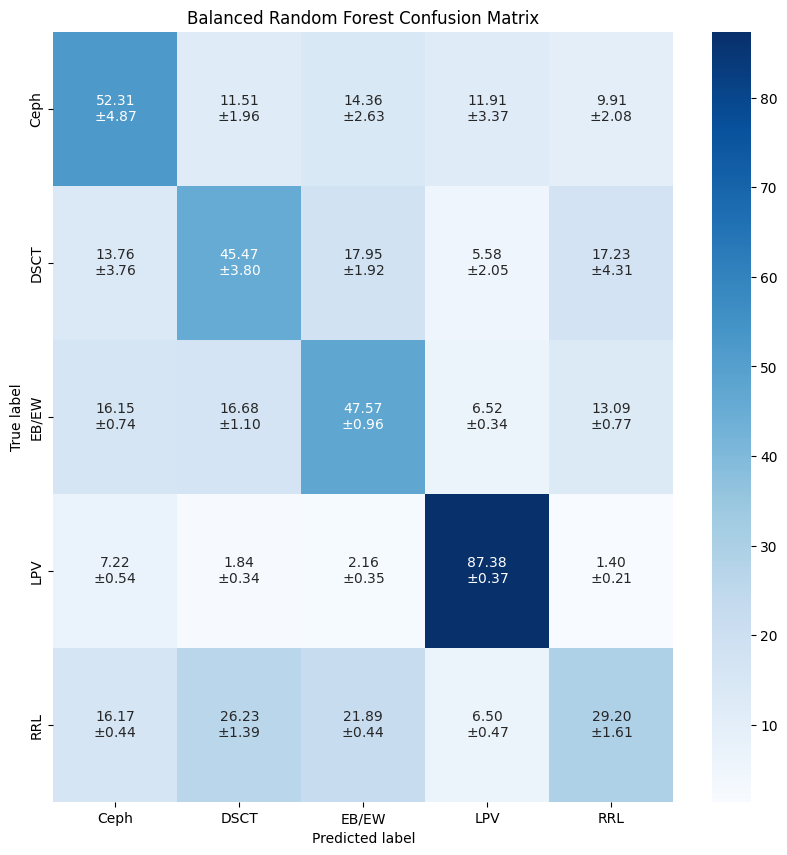

BRF entrenado usando curvas de máximo 10 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.05 ± 0.01,0.03 ± 0.0,0.74 ± 0.0,0.86 ± 0.0,0.8 ± 0.01,0.59 ± 0.0,0.5 ± 0.0
recall,0.55 ± 0.05,0.55 ± 0.05,0.62 ± 0.0,0.94 ± 0.01,0.43 ± 0.01,0.59 ± 0.0,0.62 ± 0.01
f1-score,0.09 ± 0.01,0.06 ± 0.01,0.67 ± 0.0,0.9 ± 0.0,0.56 ± 0.01,0.59 ± 0.0,0.46 ± 0.0
support,132.8 ± 8.47,159.4 ± 14.5,6503.4 ± 33.05,2665.2 ± 52.28,6864.4 ± 39.23,0.59 ± 0.0,16325.2 ± 0.4


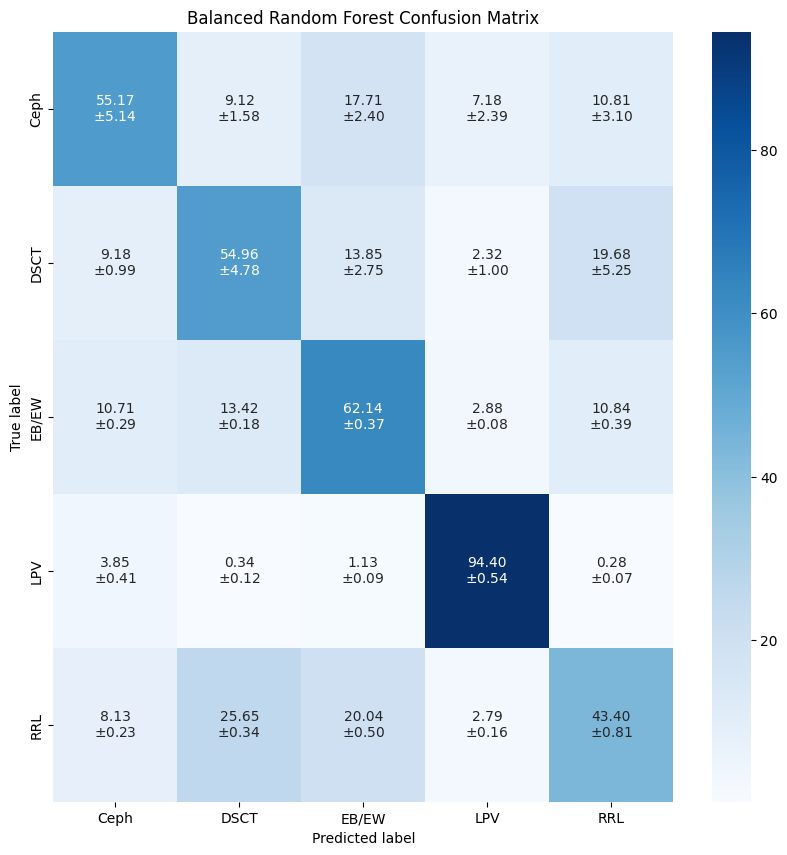

BRF entrenado usando curvas de máximo 20 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.07 ± 0.0,0.06 ± 0.0,0.86 ± 0.01,0.94 ± 0.0,0.89 ± 0.0,0.73 ± 0.0,0.56 ± 0.0
recall,0.66 ± 0.04,0.66 ± 0.02,0.73 ± 0.0,0.97 ± 0.0,0.64 ± 0.01,0.73 ± 0.0,0.73 ± 0.01
f1-score,0.13 ± 0.01,0.1 ± 0.01,0.79 ± 0.0,0.95 ± 0.0,0.74 ± 0.0,0.73 ± 0.0,0.54 ± 0.0
support,132.8 ± 5.74,159.4 ± 10.48,6503.4 ± 27.19,2665.2 ± 34.68,6864.4 ± 30.76,0.73 ± 0.0,16325.2 ± 0.4


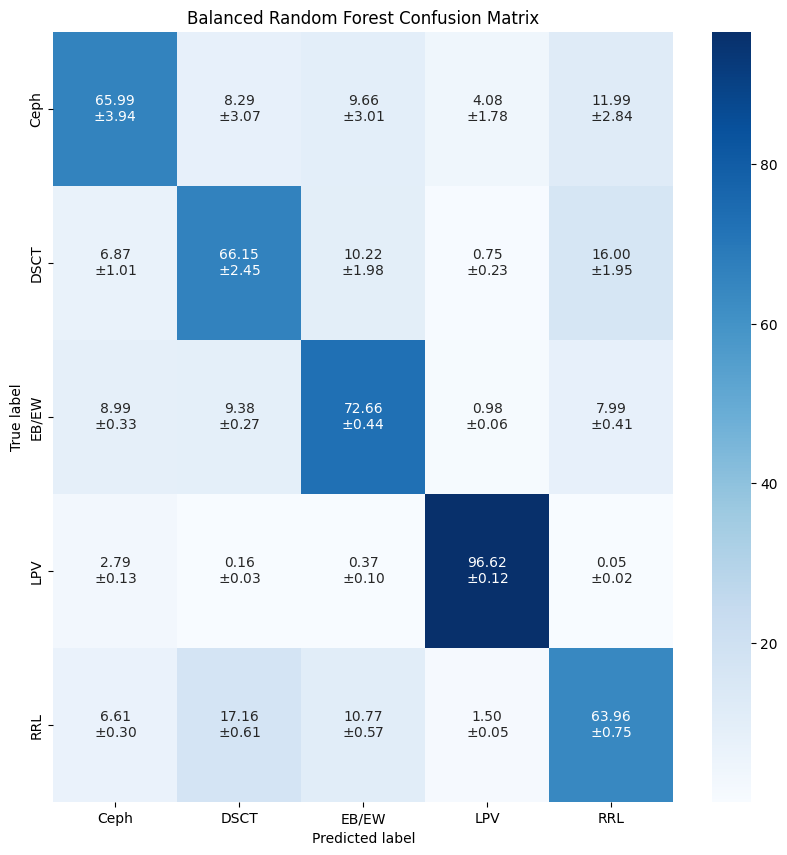

BRF entrenado usando curvas de máximo 30 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.09 ± 0.01,0.07 ± 0.0,0.91 ± 0.0,0.96 ± 0.0,0.92 ± 0.0,0.78 ± 0.0,0.59 ± 0.0
recall,0.7 ± 0.05,0.78 ± 0.05,0.77 ± 0.0,0.97 ± 0.0,0.71 ± 0.01,0.78 ± 0.0,0.79 ± 0.02
f1-score,0.16 ± 0.02,0.13 ± 0.01,0.84 ± 0.0,0.96 ± 0.0,0.8 ± 0.01,0.78 ± 0.0,0.58 ± 0.0
support,132.8 ± 8.68,159.4 ± 10.48,6503.4 ± 34.44,2665.2 ± 32.9,6864.4 ± 44.16,0.78 ± 0.0,16325.2 ± 0.4


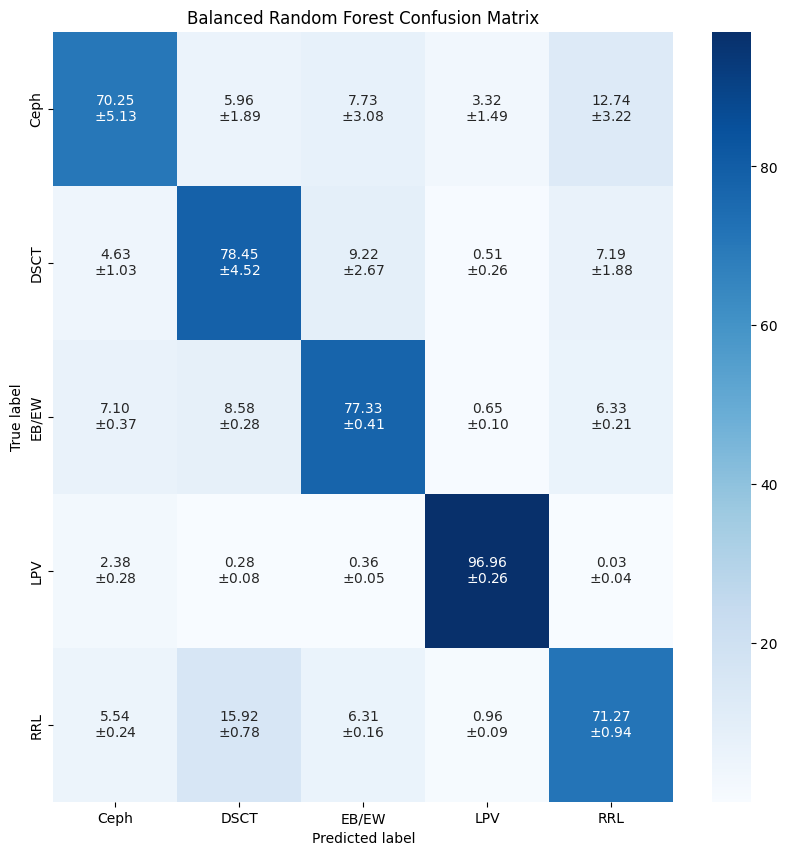

BRF entrenado usando curvas de máximo 40 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.11 ± 0.01,0.08 ± 0.0,0.93 ± 0.0,0.97 ± 0.0,0.93 ± 0.0,0.8 ± 0.0,0.6 ± 0.0
recall,0.73 ± 0.05,0.84 ± 0.02,0.8 ± 0.01,0.97 ± 0.0,0.75 ± 0.0,0.8 ± 0.0,0.82 ± 0.01
f1-score,0.19 ± 0.01,0.15 ± 0.01,0.86 ± 0.01,0.97 ± 0.0,0.83 ± 0.0,0.8 ± 0.0,0.6 ± 0.0
support,132.8 ± 12.42,159.4 ± 8.82,6503.4 ± 30.14,2665.2 ± 28.92,6864.4 ± 14.54,0.8 ± 0.0,16325.2 ± 0.4


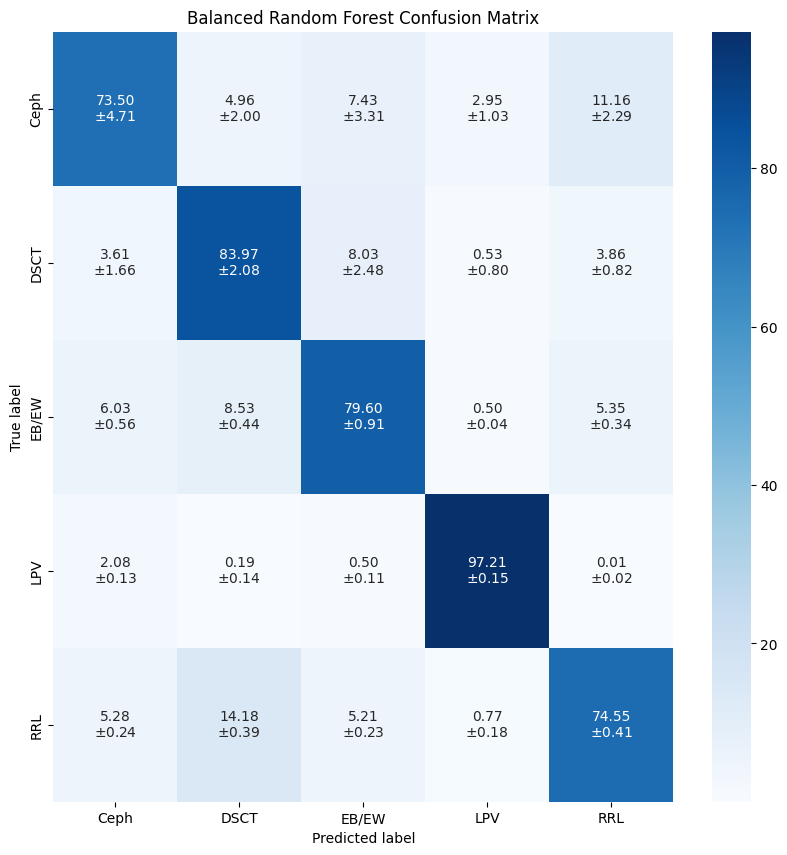

BRF entrenado usando curvas de máximo 50 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.12 ± 0.01,0.09 ± 0.01,0.94 ± 0.0,0.97 ± 0.0,0.94 ± 0.0,0.82 ± 0.0,0.61 ± 0.0
recall,0.8 ± 0.04,0.84 ± 0.04,0.81 ± 0.0,0.97 ± 0.0,0.77 ± 0.0,0.82 ± 0.0,0.84 ± 0.01
f1-score,0.2 ± 0.01,0.17 ± 0.01,0.87 ± 0.0,0.97 ± 0.0,0.85 ± 0.0,0.82 ± 0.0,0.61 ± 0.0
support,132.8 ± 8.08,159.4 ± 8.64,6503.4 ± 54.09,2665.2 ± 51.73,6864.4 ± 101.72,0.82 ± 0.0,16325.2 ± 0.4


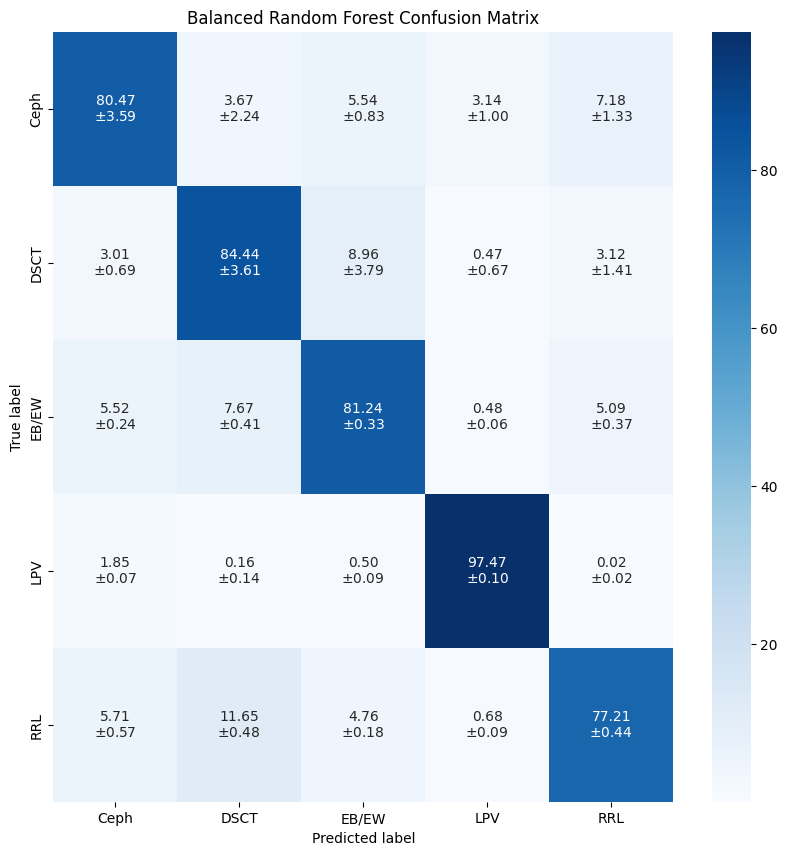

BRF entrenado usando curvas de máximo 100 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.14 ± 0.0,0.14 ± 0.01,0.94 ± 0.0,0.98 ± 0.0,0.94 ± 0.0,0.86 ± 0.0,0.63 ± 0.0
recall,0.86 ± 0.03,0.89 ± 0.02,0.84 ± 0.0,0.98 ± 0.0,0.83 ± 0.01,0.86 ± 0.0,0.88 ± 0.01
f1-score,0.24 ± 0.01,0.24 ± 0.02,0.89 ± 0.0,0.98 ± 0.0,0.88 ± 0.0,0.86 ± 0.0,0.65 ± 0.01
support,132.8 ± 6.58,159.4 ± 10.33,6503.4 ± 47.61,2665.2 ± 33.39,6864.4 ± 33.31,0.86 ± 0.0,16325.2 ± 0.4


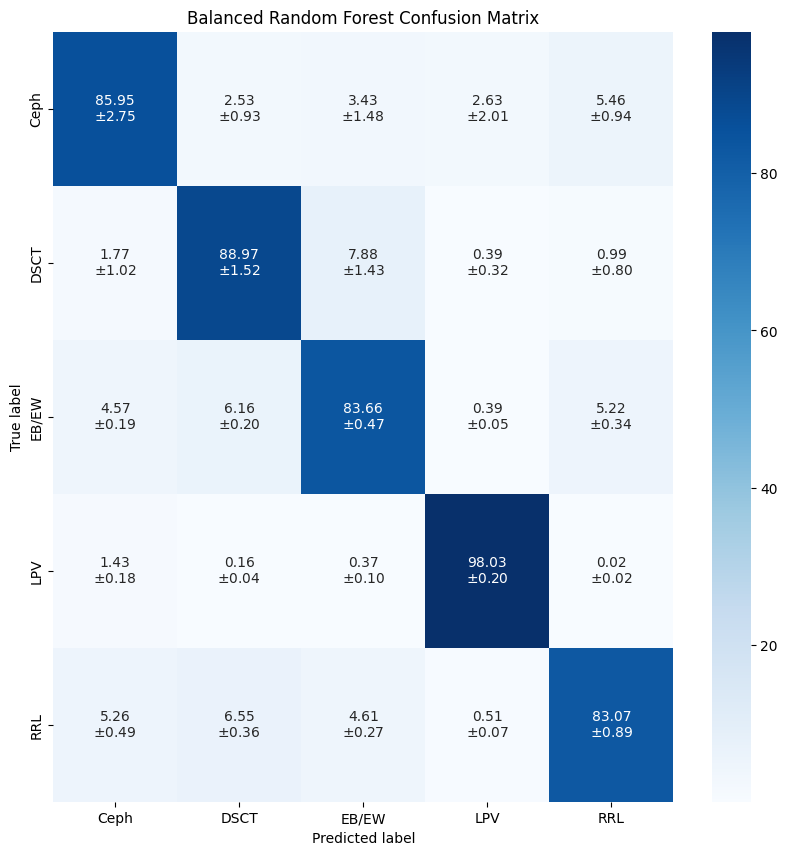

BRF entrenado usando curvas de máximo 200 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.15 ± 0.0,0.17 ± 0.01,0.94 ± 0.0,0.98 ± 0.0,0.94 ± 0.0,0.87 ± 0.0,0.64 ± 0.0
recall,0.86 ± 0.03,0.89 ± 0.02,0.85 ± 0.01,0.98 ± 0.0,0.85 ± 0.0,0.87 ± 0.0,0.89 ± 0.01
f1-score,0.25 ± 0.01,0.28 ± 0.02,0.89 ± 0.0,0.98 ± 0.0,0.89 ± 0.0,0.87 ± 0.0,0.66 ± 0.0
support,132.8 ± 7.0,159.4 ± 15.56,6503.4 ± 56.27,2665.2 ± 52.38,6864.4 ± 49.65,0.87 ± 0.0,16325.2 ± 0.4


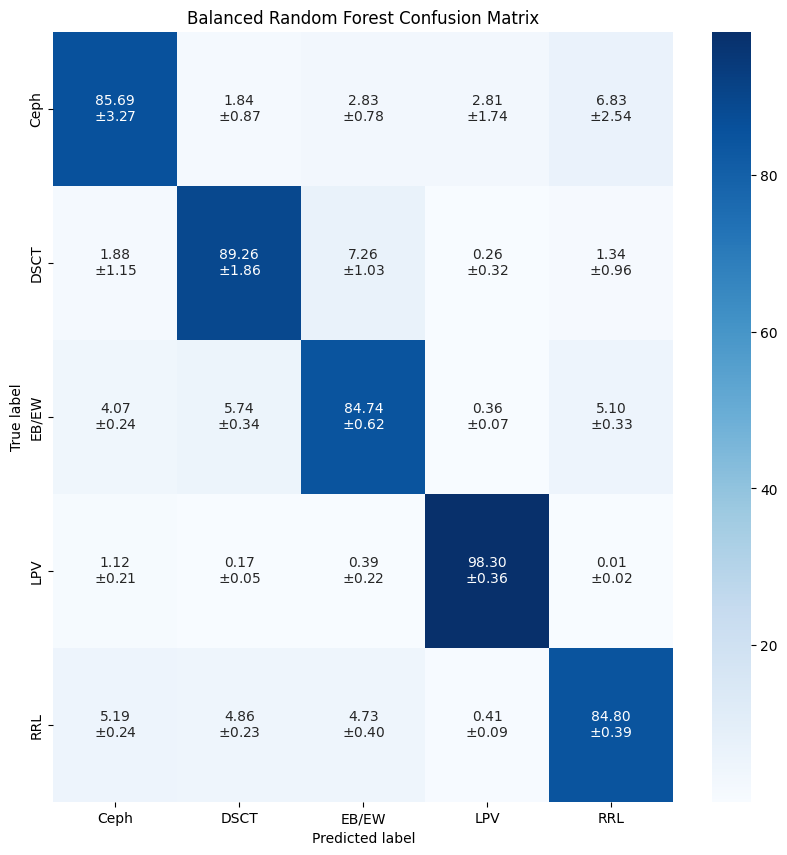

BRF entrenado usando curvas de máximo 300 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.15 ± 0.01,0.17 ± 0.01,0.94 ± 0.0,0.98 ± 0.0,0.94 ± 0.0,0.87 ± 0.0,0.63 ± 0.0
recall,0.85 ± 0.02,0.9 ± 0.02,0.84 ± 0.01,0.98 ± 0.0,0.85 ± 0.0,0.87 ± 0.0,0.88 ± 0.01
f1-score,0.25 ± 0.02,0.28 ± 0.01,0.89 ± 0.0,0.98 ± 0.0,0.89 ± 0.0,0.87 ± 0.0,0.66 ± 0.0
support,132.8 ± 12.07,159.4 ± 6.44,6503.4 ± 53.06,2665.2 ± 18.69,6864.4 ± 46.93,0.87 ± 0.0,16325.2 ± 0.4


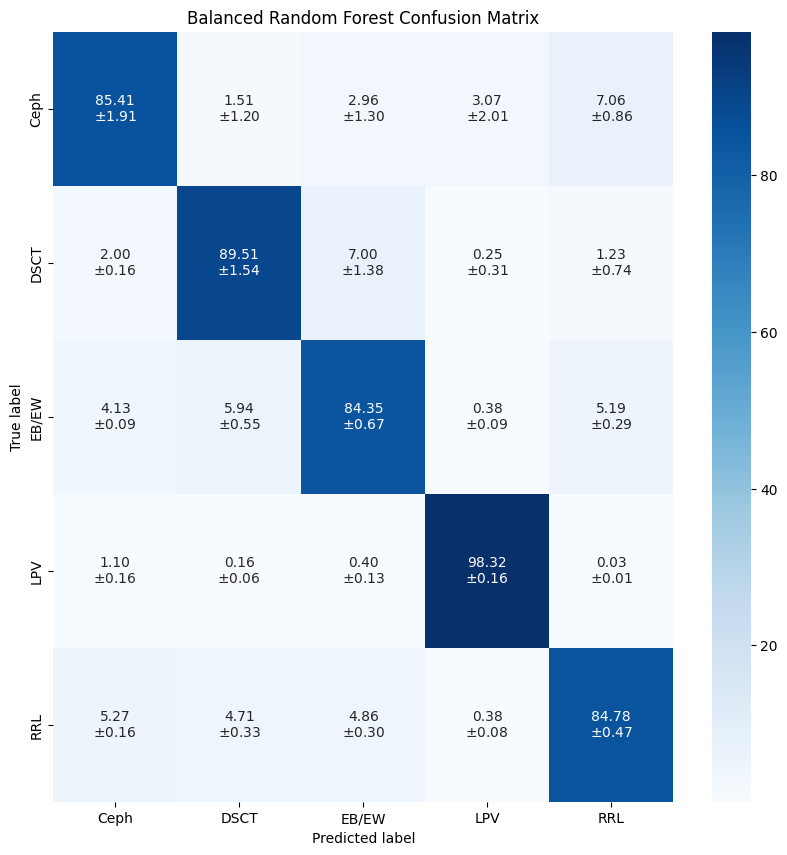

BRF entrenado usando curvas de máximo 400 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.14 ± 0.01,0.16 ± 0.01,0.94 ± 0.0,0.98 ± 0.0,0.94 ± 0.0,0.87 ± 0.0,0.63 ± 0.0
recall,0.84 ± 0.02,0.89 ± 0.03,0.84 ± 0.0,0.98 ± 0.0,0.85 ± 0.01,0.87 ± 0.0,0.88 ± 0.01
f1-score,0.24 ± 0.01,0.27 ± 0.02,0.89 ± 0.0,0.98 ± 0.0,0.89 ± 0.0,0.87 ± 0.0,0.66 ± 0.0
support,132.8 ± 11.29,159.4 ± 11.59,6503.4 ± 82.59,2665.2 ± 52.81,6864.4 ± 64.49,0.87 ± 0.0,16325.2 ± 0.4


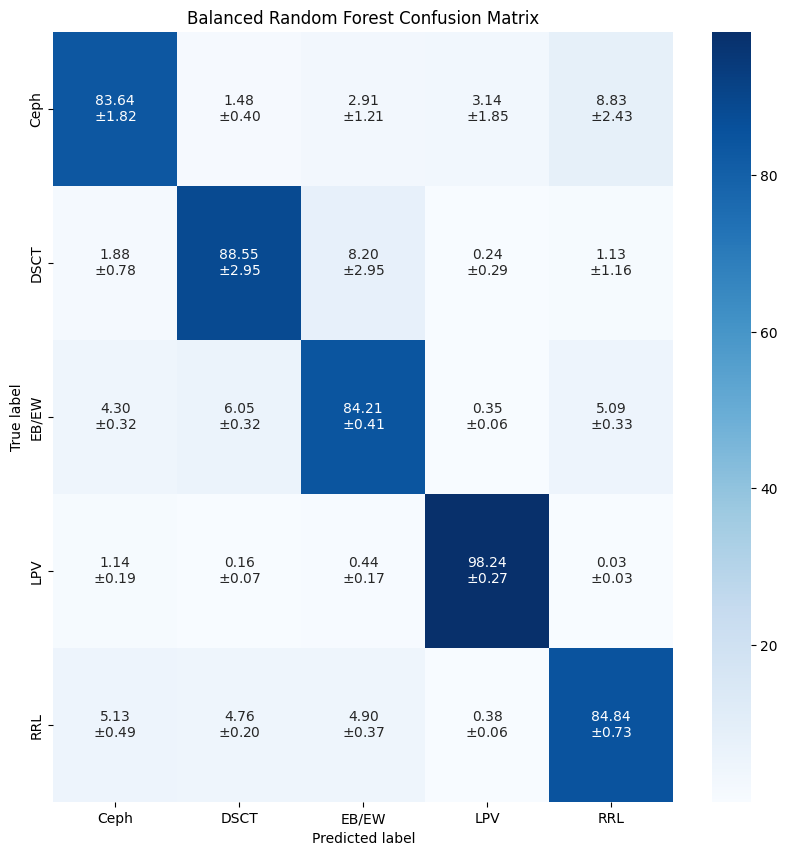

BRF entrenado usando curvas de máximo 500 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.15 ± 0.01,0.17 ± 0.01,0.94 ± 0.0,0.98 ± 0.0,0.94 ± 0.0,0.87 ± 0.0,0.64 ± 0.0
recall,0.84 ± 0.02,0.89 ± 0.02,0.85 ± 0.0,0.98 ± 0.0,0.85 ± 0.01,0.87 ± 0.0,0.88 ± 0.01
f1-score,0.25 ± 0.01,0.28 ± 0.01,0.89 ± 0.0,0.98 ± 0.0,0.9 ± 0.0,0.87 ± 0.0,0.66 ± 0.0
support,132.8 ± 11.51,159.4 ± 9.26,6503.4 ± 60.01,2665.2 ± 110.26,6864.4 ± 74.75,0.87 ± 0.0,16325.2 ± 0.4


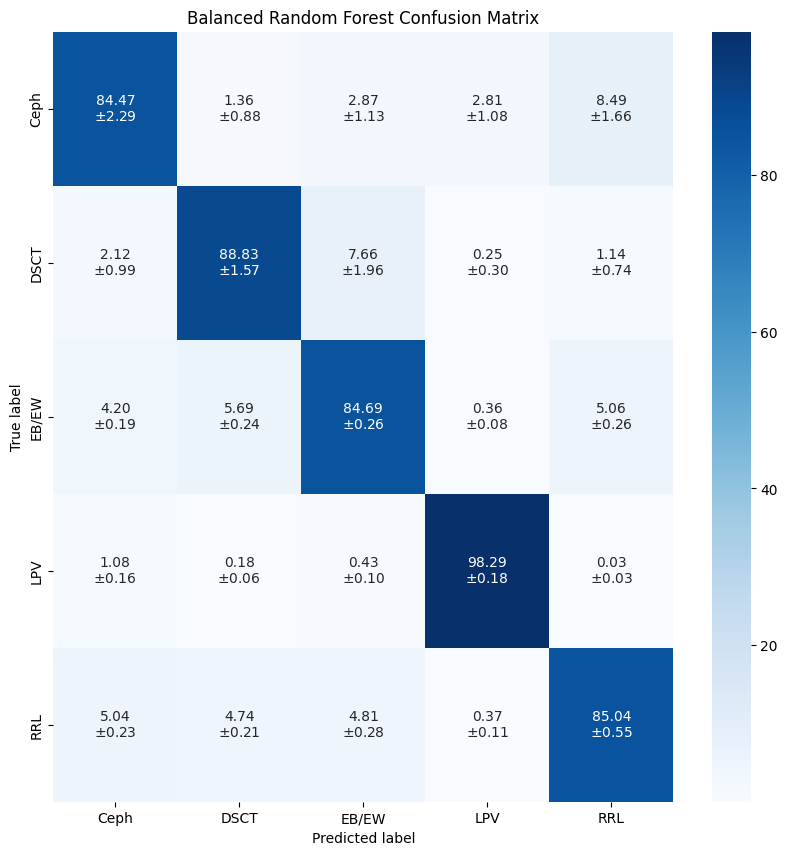

BRF entrenado usando curvas de máximo 1000 detecciones por estrella


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.14 ± 0.01,0.17 ± 0.01,0.94 ± 0.0,0.98 ± 0.0,0.94 ± 0.0,0.87 ± 0.0,0.64 ± 0.0
recall,0.84 ± 0.02,0.89 ± 0.02,0.84 ± 0.0,0.98 ± 0.0,0.85 ± 0.0,0.87 ± 0.0,0.88 ± 0.0
f1-score,0.24 ± 0.02,0.28 ± 0.02,0.89 ± 0.0,0.98 ± 0.0,0.89 ± 0.0,0.87 ± 0.0,0.66 ± 0.0
support,132.8 ± 13.88,159.4 ± 16.06,6503.4 ± 43.14,2665.2 ± 39.01,6864.4 ± 46.11,0.87 ± 0.0,16325.2 ± 0.4


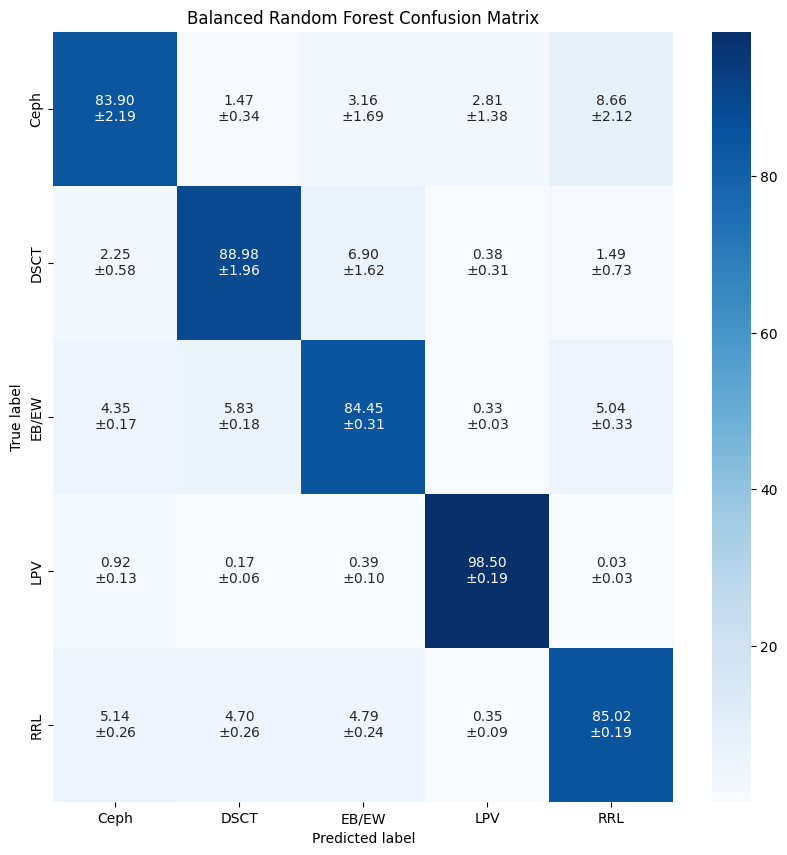

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
import warnings
warnings.simplefilter(action='ignore') # Limpiar el output de los FutureWarning de sklearn

mean_metrics_list = []
std_metrics_list = []
n_detecciones = [5,10,20,30,40,50,100,200,300,400,500,1000] # lista de número de detecciones cortadas

for n in n_detecciones:
    # Load data into a Pandas dataframe
    filename = os.path.join('data/preprocessed',f"trimmed_features_{n}_labeled.parquet")
    df = pd.read_parquet(filename)

    class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # correct order

    kf = KFold(n_splits=5, shuffle=True)

    cm_list = []
    metrics_list = []
    for train_index, test_index in kf.split(df):
        X_train, X_test = df.drop('classALeRCE', axis=1).iloc[train_index], df.drop('classALeRCE', axis=1).iloc[test_index]
        y_train, y_test = df['classALeRCE'].iloc[train_index], df['classALeRCE'].iloc[test_index]
        brf = BalancedRandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300)
        brf.fit(X_train, y_train)
        y_pred = brf.predict(X_test)

        class_report = classification_report(y_test, y_pred, output_dict=True)
        metrics_list.append(class_report)

        cm = confusion_matrix(y_test, y_pred, labels=class_labels)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
        cm_list.append(cm)

    print(f'BRF entrenado usando curvas de máximo {n} detecciones por estrella')

    mean_metrics = pd.DataFrame(metrics_list[0])
    for metricas in metrics_list[1:]:
        mean_metrics += pd.DataFrame(metricas)
    mean_metrics = mean_metrics/len(metrics_list)
    mean_metrics_list.append(mean_metrics)

    std_metrics = (pd.DataFrame(metrics_list[0])-mean_metrics).pow(2)
    for metricas in metrics_list[1:]:
        std_metrics += (pd.DataFrame(metricas)-mean_metrics).pow(2)
    std_metrics = (std_metrics/len(metrics_list)).pow(0.5)
    std_metrics_list.append(std_metrics)

    report = mean_metrics.round(2).astype(str) + ' ± ' + std_metrics.round(2).astype(str)
    report = report.drop('weighted avg', axis=1)
    display(report)

    # Matriz de confusión con promedio y desviación estándar de los k-folds
    cm_list = np.array(cm_list)
    cm_list.shape

    cm_mean = np.mean(cm_list, axis=0)
    cm_std = np.std(cm_list, axis=0)

    text = []
    thresh = cm_mean.max() / 2.
    for i in range(cm_mean.shape[0]):
        for j in range(cm_mean.shape[1]):
            text.append('{0:.2f}'.format(cm_mean[i, j]) + '\n$\pm$' + '{0:.2f}'.format(cm_std[i, j]))

    text = np.asarray(text).reshape(cm_mean.shape[0], cm_mean.shape[1])

    plt.figure(figsize=(10,10))
    sns.heatmap(cm_mean, annot=text, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Balanced Random Forest Confusion Matrix')
    plt.show()

#### Gráficos de las macro-métricas promedio en los k-folds, según el largo máximo de las curvas de luz

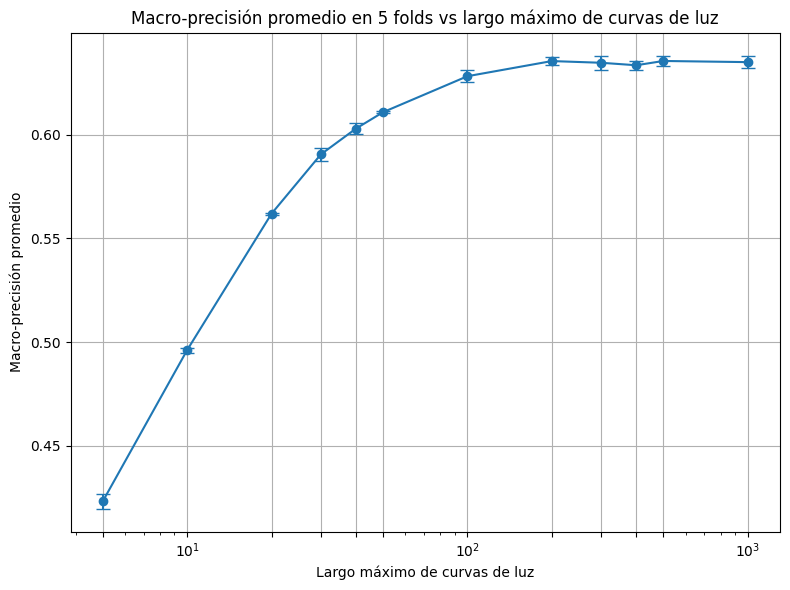

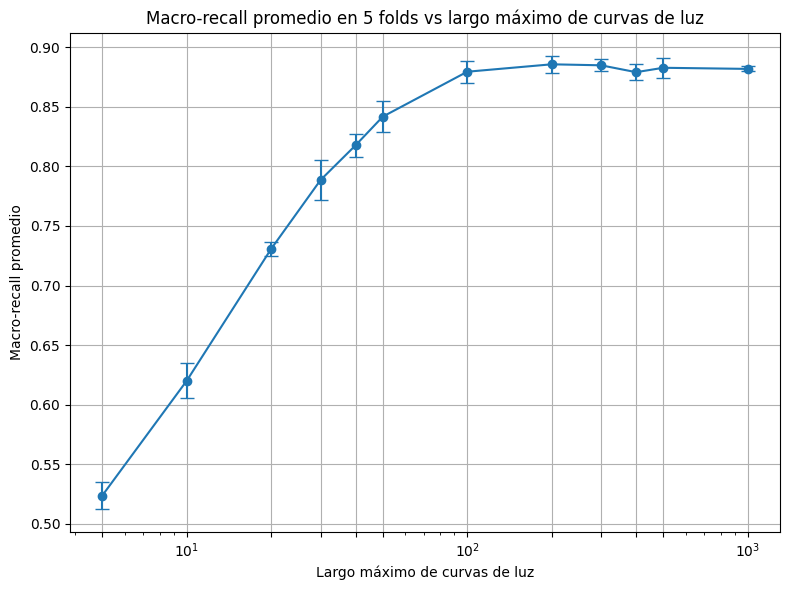

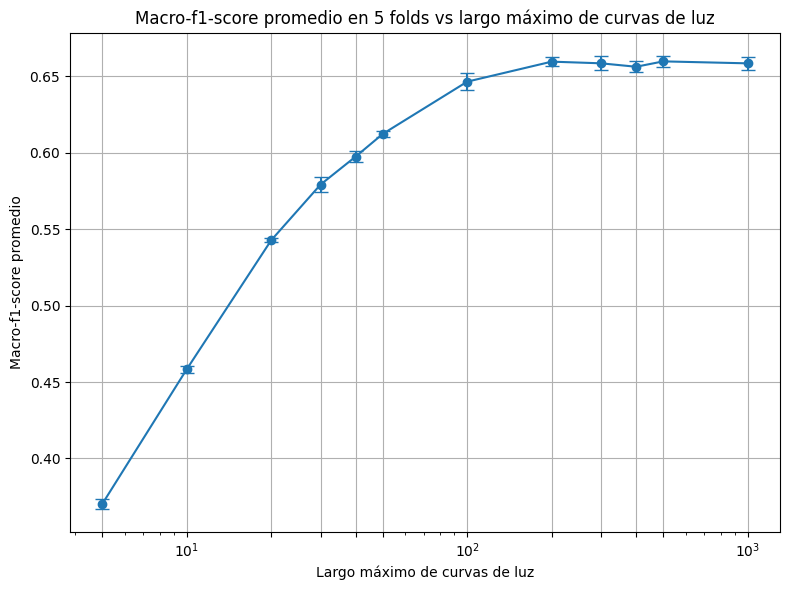

In [ ]:
import matplotlib.pyplot as plt

# df con los promedios de las macro-métricas
mean_macro_avg_list = [df['macro avg'] for df in mean_metrics_list]
# promedios de cada macro-métrica
mean_macro_precision_list = [df['precision'] for df in mean_macro_avg_list]
mean_macro_recall_list = [df['recall'] for df in mean_macro_avg_list]
mean_macro_f1score_list = [df['f1-score'] for df in mean_macro_avg_list]

# df con las desviaciones estándar de las macreo-métricas
std_macro_avg_list = [df['macro avg'] for df in std_metrics_list]
# desviaciones estándar de cada macro-métrica
std_macro_precision_list = [df['precision'] for df in std_macro_avg_list]
std_macro_recall_list = [df['recall'] for df in std_macro_avg_list]
std_macro_f1score_list = [df['f1-score'] for df in std_macro_avg_list]

# gráfico de la macro-precisión según el largo máximo de las curvas de luz
plt.figure(figsize=(8, 6))
# gráfico con barras de error para los k-folds
plt.errorbar(n_detecciones, mean_macro_precision_list, yerr=std_macro_precision_list, fmt='o-', capsize=5)
plt.xlabel('Largo máximo de curvas de luz')
plt.ylabel('Macro-precisión promedio')
plt.title('Macro-precisión promedio en 5 folds vs largo máximo de curvas de luz')

plt.xscale('log') # escala logarítmica para mejor visualización
plt.grid(True)
plt.xticks(n_detecciones) # puntos de interés del eje x
plt.tight_layout()

plt.show()

# gráfico del macro-recall según el largo máximo de las curvas de luz
plt.figure(figsize=(8, 6))
# gráfico con barras de error para los k-folds
plt.errorbar(n_detecciones, mean_macro_recall_list, yerr=std_macro_recall_list, fmt='o-', capsize=5)
plt.xlabel('Largo máximo de curvas de luz')
plt.ylabel('Macro-recall promedio')
plt.title('Macro-recall promedio en 5 folds vs largo máximo de curvas de luz')

plt.xscale('log') # escala logarítmica para mejor visualización
plt.grid(True)
plt.xticks(n_detecciones) # puntos de interés del eje x
plt.tight_layout()

plt.show()

# gráfico del macro-f1-score según el largo máximo de las curvas de luz
plt.figure(figsize=(8, 6))
# gráfico con barras de error para los k-folds
plt.errorbar(n_detecciones, mean_macro_f1score_list, yerr=std_macro_f1score_list, fmt='o-', capsize=5)
plt.xlabel('Largo máximo de curvas de luz')
plt.ylabel('Macro-f1-score promedio')
plt.title('Macro-f1-score promedio en 5 folds vs largo máximo de curvas de luz')

plt.xscale('log') # escala logarítmica para mejor visualización
plt.grid(True)
plt.xticks(n_detecciones) # puntos de interés del eje x
plt.tight_layout()

plt.show()

## Data augmentation

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

df_completo = pd.read_parquet('data/preprocessed/features_recalcv4_labeled.parquet')
df_completo = df_completo.sort_index()
X_train_completo, X_test_completo, y_train_completo, y_test_completo = train_test_split(df_completo.drop('classALeRCE', axis=1), df_completo['classALeRCE'], test_size=0.2, random_state=46)

n_detecciones = [5,10,20,30,40,50,100,200,300,400,500,1000]

for n in n_detecciones:
  filename = os.path.join('data/preprocessed/',f"trimmed_features_{n}_labeled.parquet")
  df_current = pd.read_parquet(filename)

  df_completo = pd.concat([df_completo,df_current])

  X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(df_current.drop('classALeRCE', axis=1), df_current['classALeRCE'], test_size=0.2, random_state=46)

  X_train_completo = pd.concat([X_train_completo,X_train_current])
  X_test_completo = pd.concat([X_test_completo,X_test_current])
  y_train_completo = pd.concat([y_train_completo,y_train_current])
  y_test_completo = pd.concat([y_test_completo,y_test_current])

TRAIN: [      0       1       2 ... 1061135 1061136 1061137] TEST: [     15      22      23 ... 1061131 1061132 1061134]
TRAIN: [      1       4       5 ... 1061134 1061135 1061136] TEST: [      0       2       3 ... 1061126 1061129 1061137]
TRAIN: [      0       2       3 ... 1061135 1061136 1061137] TEST: [      1       7      10 ... 1061108 1061111 1061122]
TRAIN: [      0       1       2 ... 1061134 1061136 1061137] TEST: [     18      19      20 ... 1061121 1061123 1061135]
TRAIN: [      0       1       2 ... 1061134 1061135 1061137] TEST: [      4       5       6 ... 1061130 1061133 1061136]


,Ceph,DSCT,EB/EW,LPV,RRL,accuracy,macro avg
precision,0.16 ± 0.0,0.13 ± 0.0,0.9 ± 0.0,0.95 ± 0.0,0.93 ± 0.0,0.84 ± 0.0,0.61 ± 0.0
recall,0.84 ± 0.01,0.86 ± 0.01,0.84 ± 0.0,0.98 ± 0.0,0.79 ± 0.0,0.84 ± 0.0,0.86 ± 0.0
f1-score,0.27 ± 0.0,0.23 ± 0.0,0.87 ± 0.0,0.96 ± 0.0,0.85 ± 0.0,0.84 ± 0.0,0.64 ± 0.0
support,1726.4 ± 49.48,2072.2 ± 22.2,84544.2 ± 210.94,34647.6 ± 130.08,89237.2 ± 122.9,0.84 ± 0.0,212227.6 ± 0.49


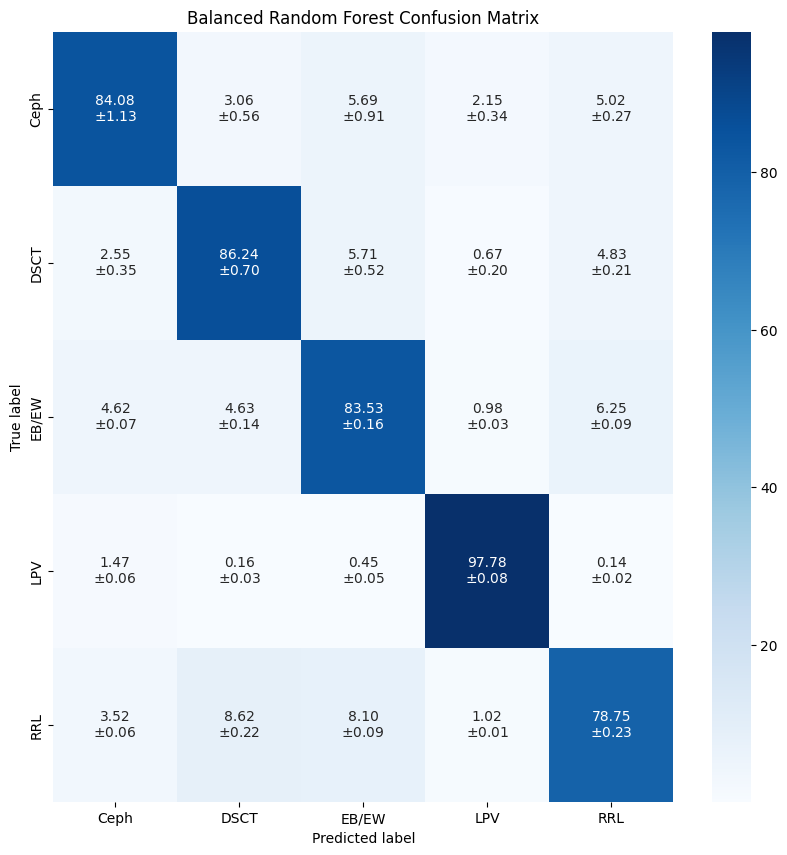

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter(action='ignore') # Limpiar el output de los FutureWarning de sklearn

# Cargar datos
df = df_completo

class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # lista de clases

kf = KFold(n_splits=5, shuffle=True) # usar 5 folds (20% validación)

cm_list = [] # inicialización lista con matrices de confusión para cada fold
metrics_list = [] # inicialización lista con macro-métricas para cada fold

for train_index, test_index in kf.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df.drop('classALeRCE', axis=1).iloc[train_index], df.drop('classALeRCE', axis=1).iloc[test_index]
    y_train, y_test = df['classALeRCE'].iloc[train_index], df['classALeRCE'].iloc[test_index]
    brf = BalancedRandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300)
    brf.fit(X_train, y_train)
    y_pred = brf.predict(X_test)

    class_report = classification_report(y_test, y_pred, output_dict=True)
    metrics_list.append(class_report) # lista con macro-métricas para cada fold

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    cm_list.append(cm) # lista con matrices de confusión para cada fold

# cálculo promedio de las macro-métricas en los k-folds
mean_metrics = pd.DataFrame(metrics_list[0])
for metricas in metrics_list[1:]:
    mean_metrics += pd.DataFrame(metricas)
mean_metrics = mean_metrics/len(metrics_list)

# cálculo desviación estándar de las macro-métricas en los k-folds
std_metrics = (pd.DataFrame(metrics_list[0])-mean_metrics).pow(2)
for metricas in metrics_list[1:]:
    std_metrics += (pd.DataFrame(metricas)-mean_metrics).pow(2)
std_metrics = (std_metrics/len(metrics_list)).pow(0.5)

# df con los valores promedio ± desviación estándar para las macro-métricas en los k-folds
report = mean_metrics.round(2).astype(str) + ' ± ' + std_metrics.round(2).astype(str)
report = report.drop('weighted avg', axis=1)
display(report)

# Matriz de confusión con promedio y desviación estándar de los k-folds
cm_list = np.array(cm_list)
cm_list.shape

cm_mean = np.mean(cm_list, axis=0)
cm_std = np.std(cm_list, axis=0)

text = []
thresh = cm_mean.max() / 2.
for i in range(cm_mean.shape[0]):
    for j in range(cm_mean.shape[1]):
        text.append('{0:.2f}'.format(cm_mean[i, j]) + '\n$\pm$' + '{0:.2f}'.format(cm_std[i, j]))

text = np.asarray(text).reshape(cm_mean.shape[0], cm_mean.shape[1])

plt.figure(figsize=(10,10))
sns.heatmap(cm_mean, annot=text, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Balanced Random Forest Confusion Matrix')
plt.show()

BRF entrenado usando curvas de máximo 5 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.04      0.76      0.08       130
        DSCT       0.04      0.80      0.08       154
       EB/EW       0.65      0.51      0.57      6484
         LPV       0.74      0.88      0.80      2699
         RRL       0.70      0.26      0.38      6859

    accuracy                           0.47     16326
   macro avg       0.43      0.64      0.38     16326
weighted avg       0.67      0.47      0.52     16326



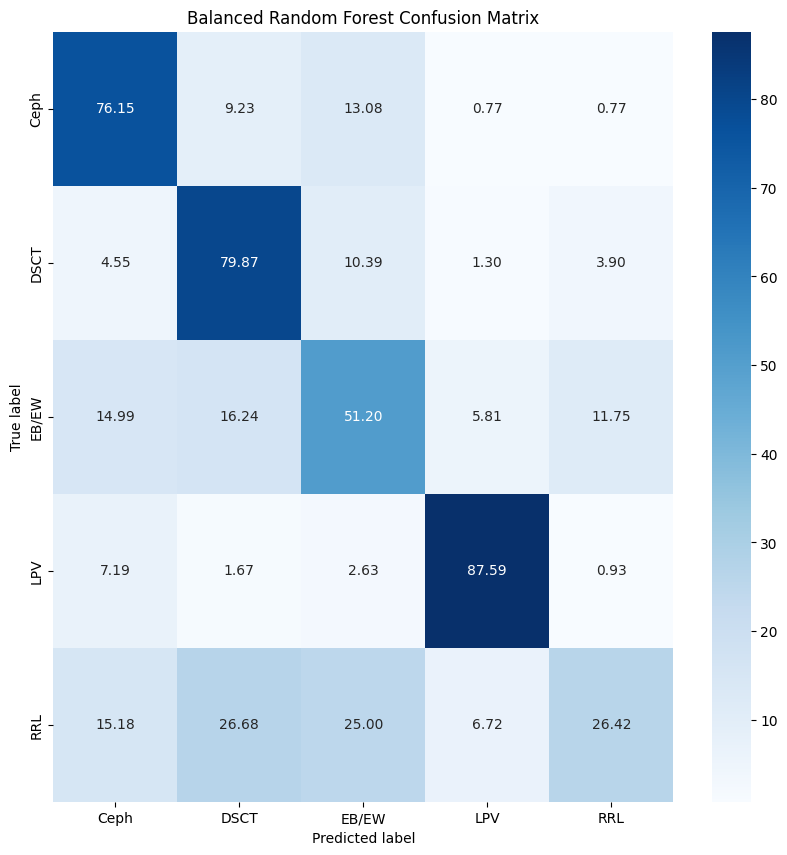

BRF entrenado usando curvas de máximo 10 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.10      0.88      0.18       130
        DSCT       0.07      0.92      0.12       154
       EB/EW       0.73      0.69      0.71      6484
         LPV       0.89      0.94      0.92      2699
         RRL       0.82      0.49      0.61      6859

    accuracy                           0.65     16326
   macro avg       0.52      0.78      0.51     16326
weighted avg       0.78      0.65      0.69     16326



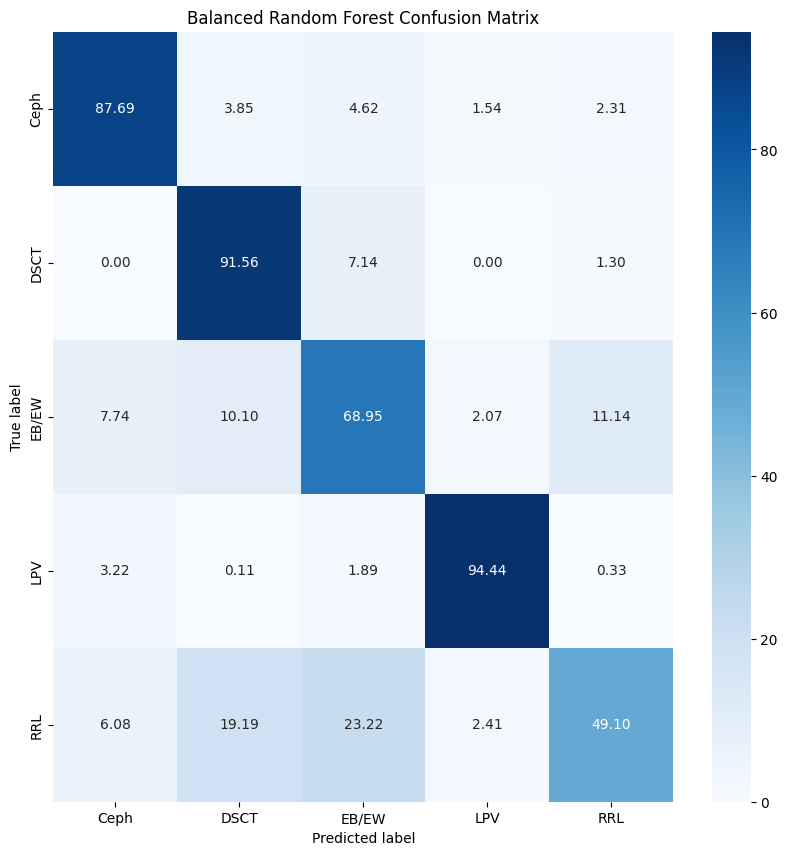

BRF entrenado usando curvas de máximo 20 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.18      0.95      0.30       130
        DSCT       0.09      0.94      0.16       154
       EB/EW       0.85      0.81      0.83      6484
         LPV       0.96      0.97      0.97      2699
         RRL       0.91      0.67      0.77      6859

    accuracy                           0.78     16326
   macro avg       0.60      0.87      0.60     16326
weighted avg       0.88      0.78      0.82     16326



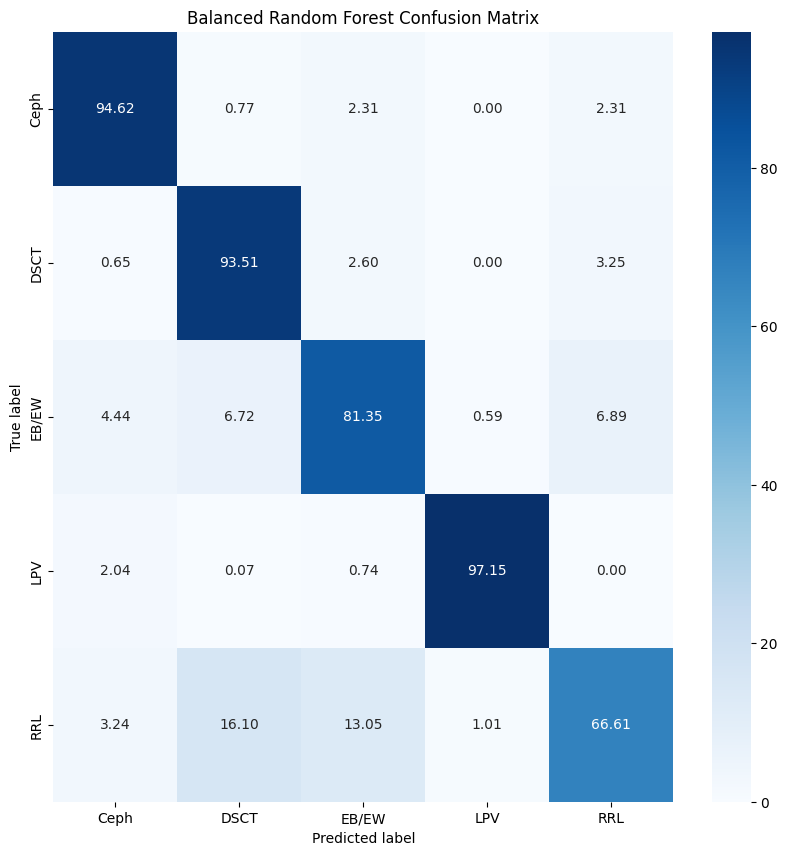

BRF entrenado usando curvas de máximo 30 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.21      0.92      0.34       130
        DSCT       0.11      0.95      0.20       154
       EB/EW       0.91      0.85      0.88      6484
         LPV       0.98      0.98      0.98      2699
         RRL       0.93      0.77      0.85      6859

    accuracy                           0.84     16326
   macro avg       0.63      0.89      0.65     16326
weighted avg       0.92      0.84      0.87     16326



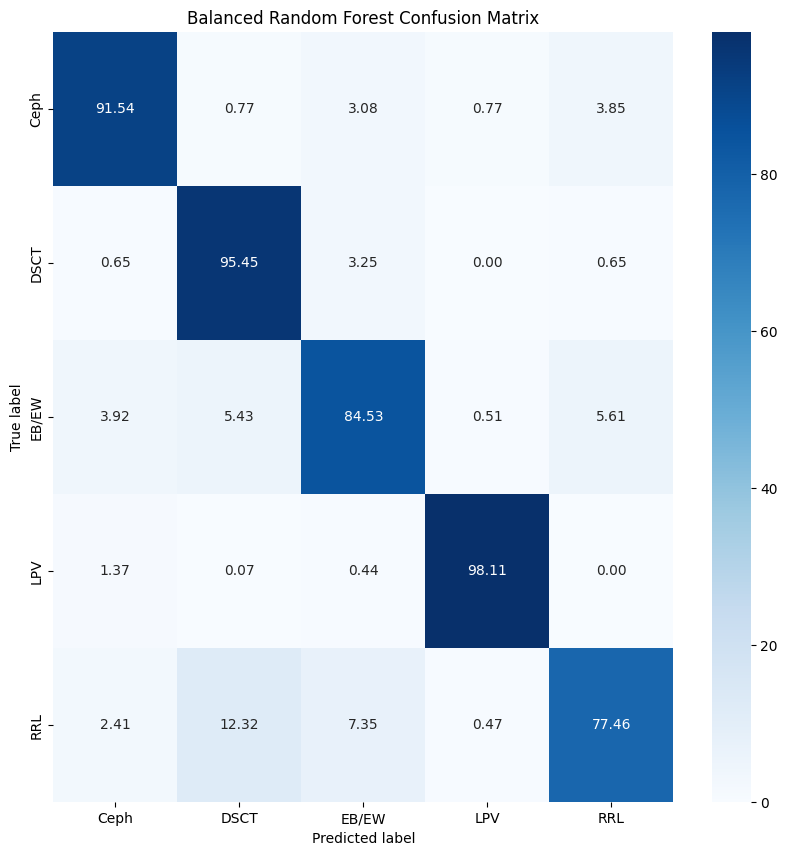

BRF entrenado usando curvas de máximo 40 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.25      0.95      0.40       130
        DSCT       0.13      0.95      0.22       154
       EB/EW       0.93      0.86      0.90      6484
         LPV       0.98      0.99      0.98      2699
         RRL       0.94      0.82      0.88      6859

    accuracy                           0.87     16326
   macro avg       0.65      0.91      0.68     16326
weighted avg       0.93      0.87      0.89     16326



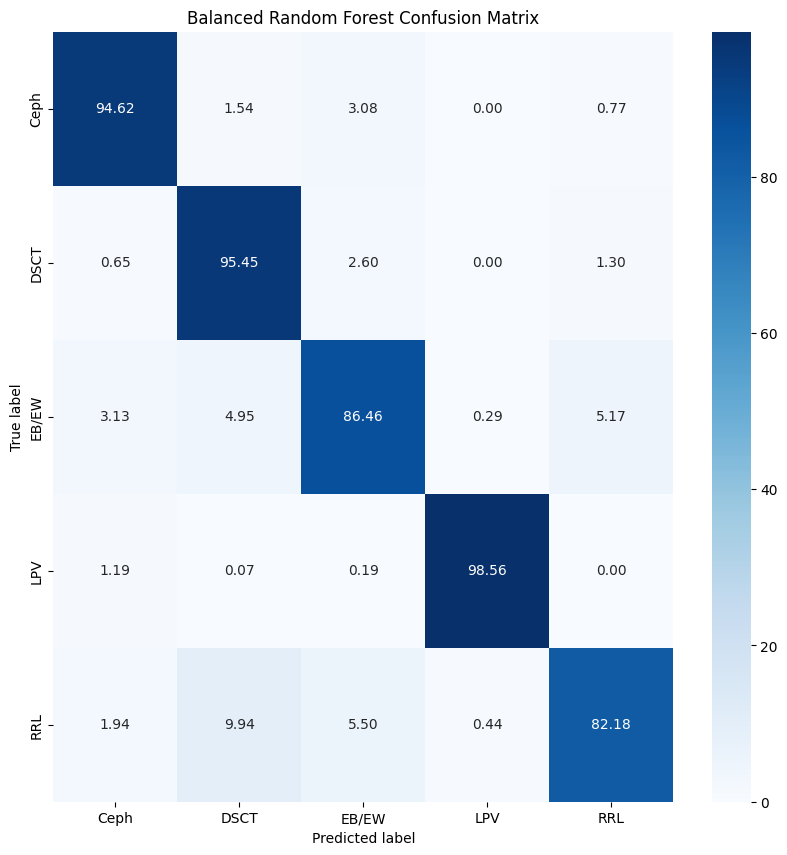

BRF entrenado usando curvas de máximo 50 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.26      0.95      0.41       130
        DSCT       0.16      0.99      0.27       154
       EB/EW       0.94      0.88      0.91      6484
         LPV       0.99      0.99      0.99      2699
         RRL       0.94      0.85      0.89      6859

    accuracy                           0.89     16326
   macro avg       0.66      0.93      0.70     16326
weighted avg       0.94      0.89      0.91     16326



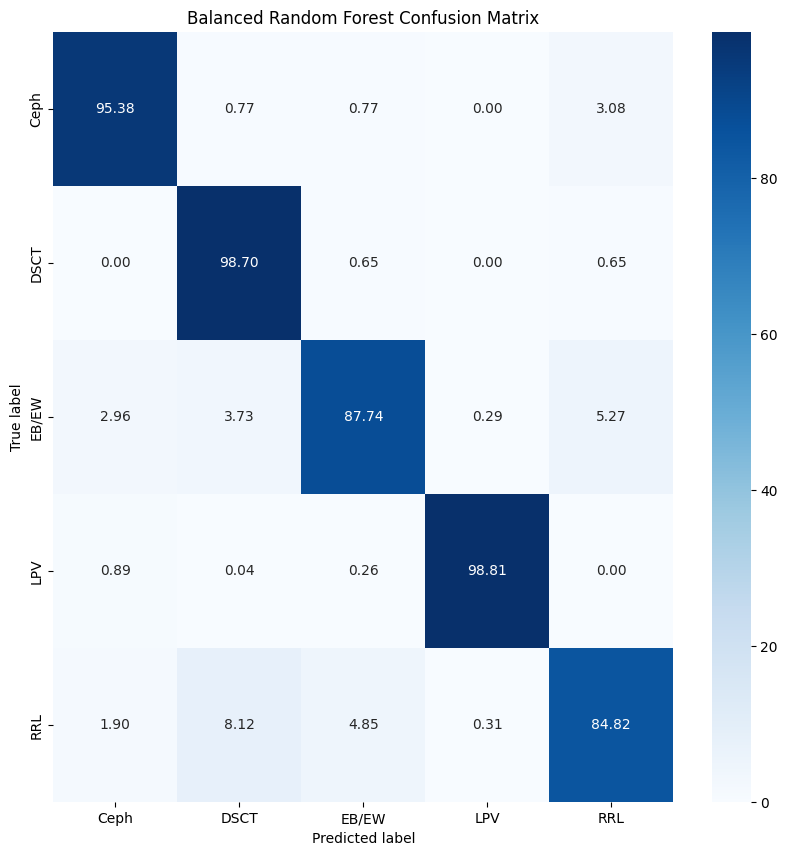

BRF entrenado usando curvas de máximo 100 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.31      0.98      0.47       130
        DSCT       0.28      0.99      0.43       154
       EB/EW       0.95      0.89      0.92      6484
         LPV       0.99      0.99      0.99      2699
         RRL       0.95      0.91      0.93      6859

    accuracy                           0.92     16326
   macro avg       0.70      0.95      0.75     16326
weighted avg       0.94      0.92      0.93     16326



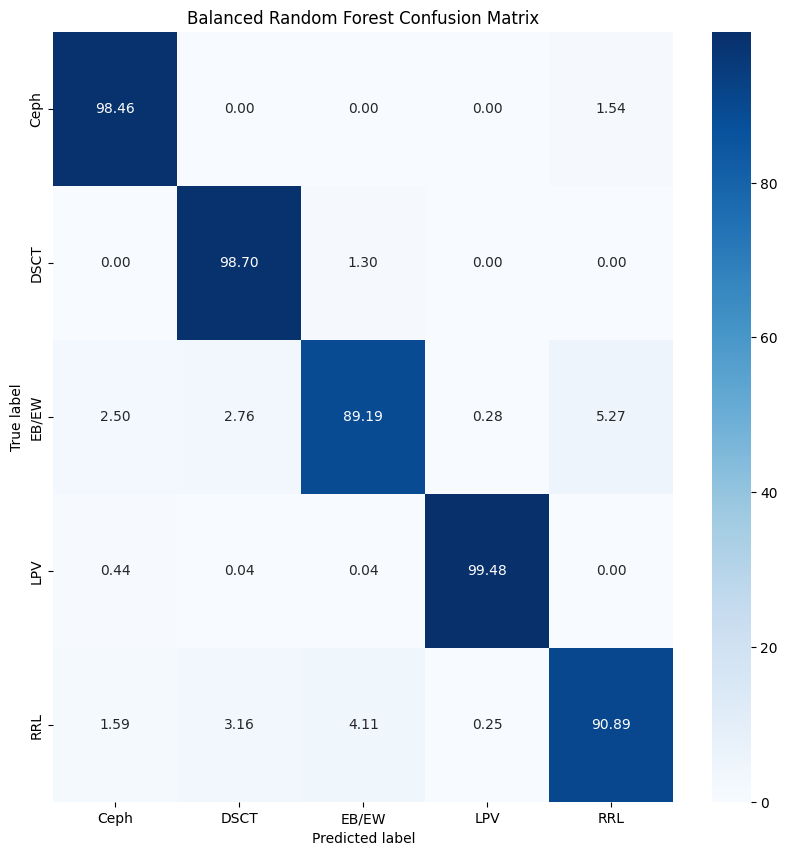

BRF entrenado usando curvas de máximo 200 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.33      0.99      0.49       130
        DSCT       0.37      0.99      0.54       154
       EB/EW       0.96      0.90      0.93      6484
         LPV       0.99      1.00      0.99      2699
         RRL       0.95      0.93      0.94      6859

    accuracy                           0.93     16326
   macro avg       0.72      0.96      0.78     16326
weighted avg       0.95      0.93      0.94     16326



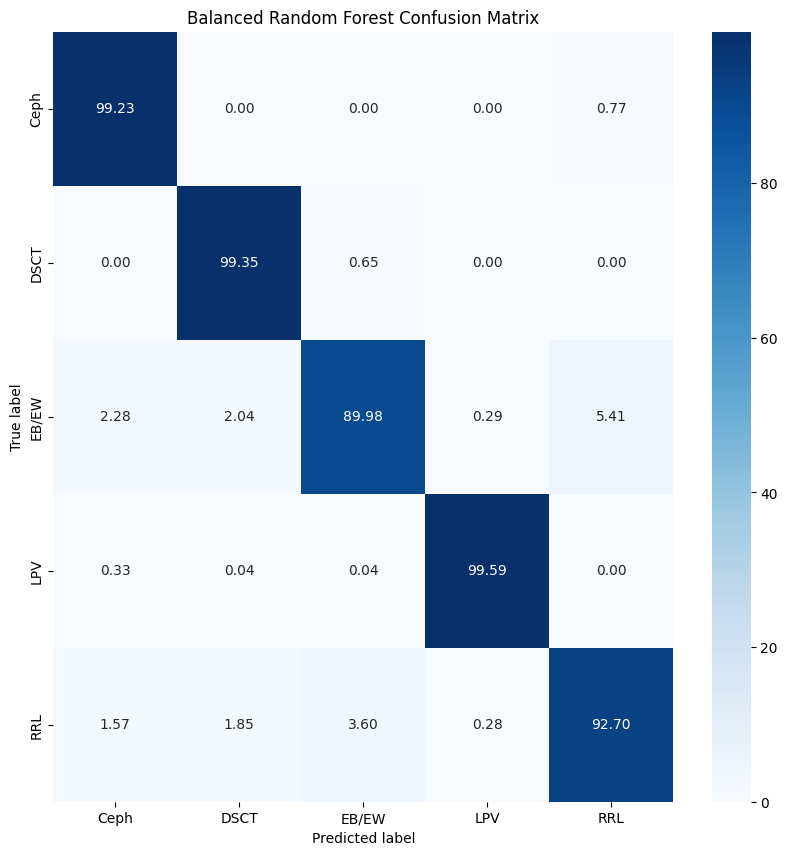

BRF entrenado usando curvas de máximo 300 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.33      1.00      0.49       130
        DSCT       0.38      0.99      0.55       154
       EB/EW       0.96      0.90      0.93      6484
         LPV       0.99      1.00      0.99      2699
         RRL       0.95      0.93      0.94      6859

    accuracy                           0.93     16326
   macro avg       0.72      0.96      0.78     16326
weighted avg       0.95      0.93      0.94     16326



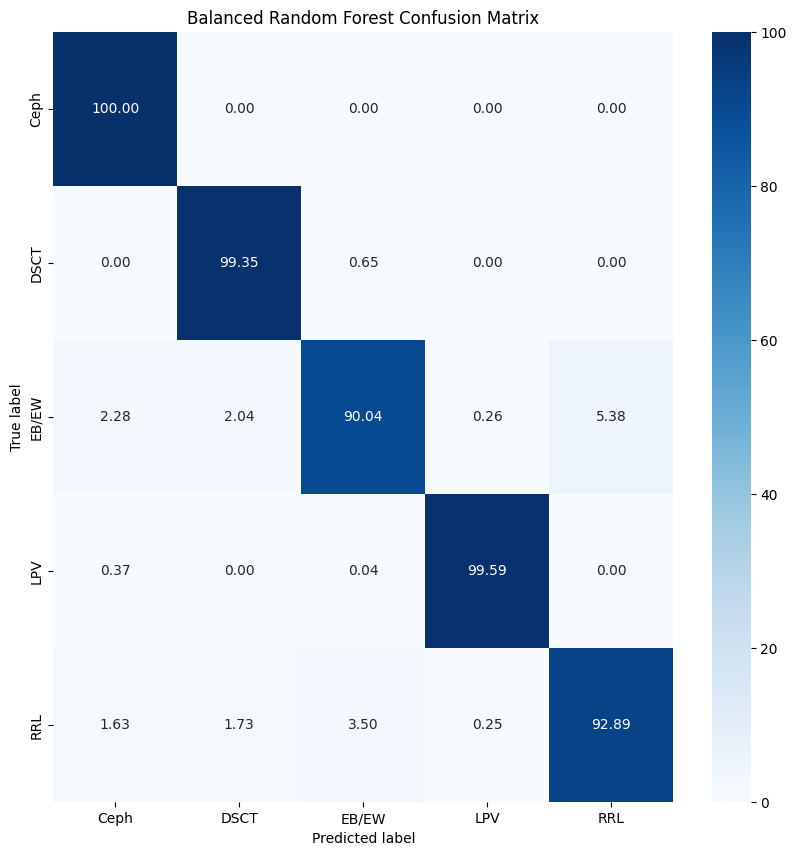

BRF entrenado usando curvas de máximo 400 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.33      1.00      0.49       130
        DSCT       0.39      0.99      0.55       154
       EB/EW       0.96      0.90      0.93      6484
         LPV       0.99      1.00      0.99      2699
         RRL       0.95      0.93      0.94      6859

    accuracy                           0.93     16326
   macro avg       0.72      0.96      0.78     16326
weighted avg       0.95      0.93      0.94     16326



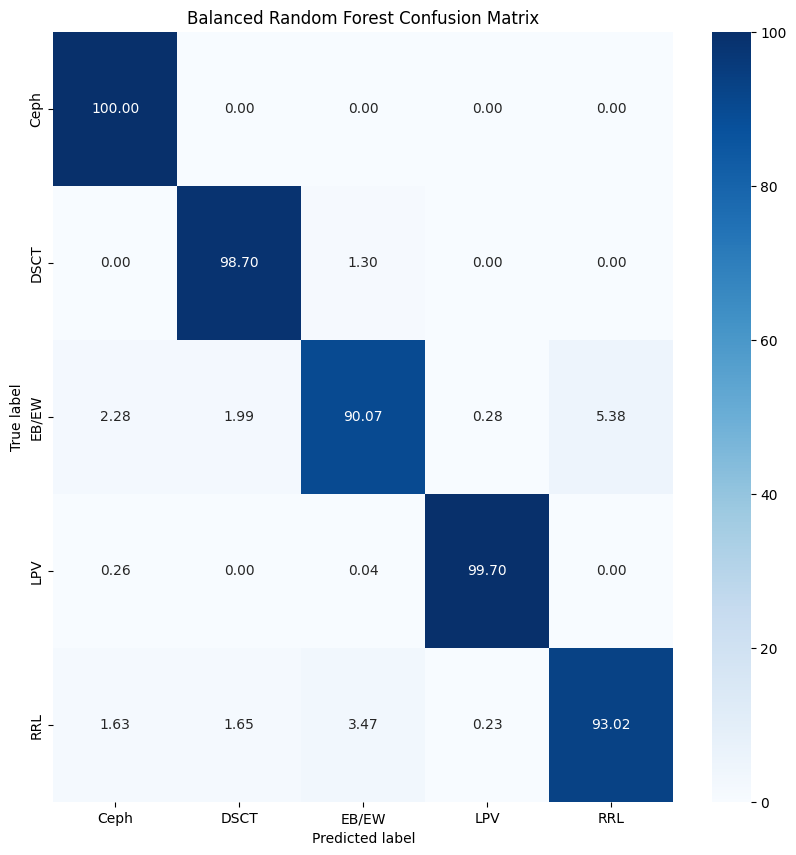

BRF entrenado usando curvas de máximo 500 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.32      1.00      0.49       130
        DSCT       0.39      1.00      0.56       154
       EB/EW       0.96      0.90      0.93      6484
         LPV       0.99      1.00      0.99      2699
         RRL       0.95      0.93      0.94      6859

    accuracy                           0.93     16326
   macro avg       0.72      0.97      0.78     16326
weighted avg       0.95      0.93      0.94     16326



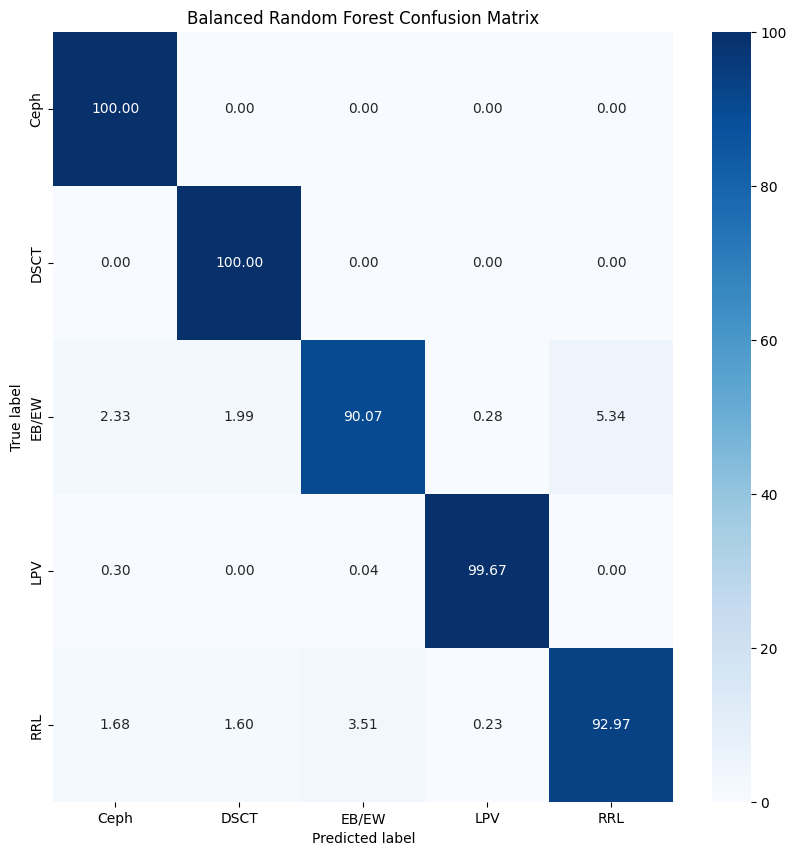

BRF entrenado usando curvas de máximo 1000 detecciones por estrella
              precision    recall  f1-score   support

        Ceph       0.32      1.00      0.48       130
        DSCT       0.39      1.00      0.56       154
       EB/EW       0.96      0.90      0.93      6484
         LPV       0.99      1.00      0.99      2699
         RRL       0.95      0.93      0.94      6859

    accuracy                           0.93     16326
   macro avg       0.72      0.97      0.78     16326
weighted avg       0.95      0.93      0.94     16326



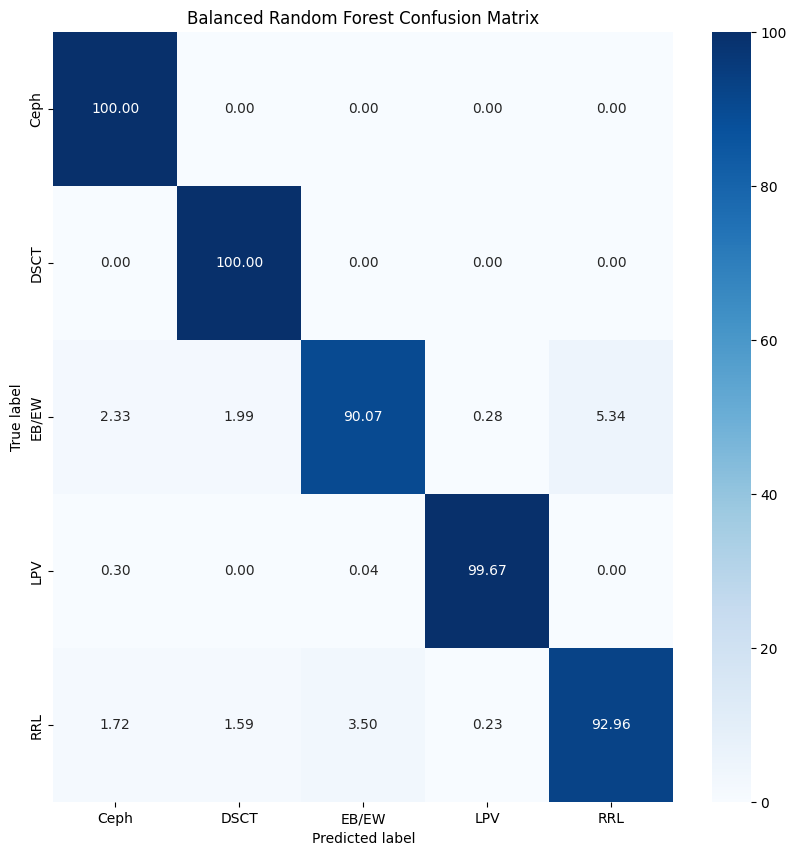

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
import warnings
warnings.simplefilter(action='ignore') # Limpiar el output de los FutureWarning de sklearn

n_detecciones = [5,10,20,30,40,50,100,200,300,400,500,1000]

metrics_list = []
for n in n_detecciones:
    class_labels = ['Ceph', 'DSCT', 'EB/EW', 'LPV', 'RRL'] # correct order

    # Datos
    filename = os.path.join('data/preprocessed',f'trimmed_features_{n}_labeled.parquet')
    df = pd.read_parquet(filename)
    df = df.sort_index()

    # Separación de datos en conjuntos de entrenamiento y validación
    X_train, X_test, y_train, y_test = train_test_split(df.drop('classALeRCE', axis=1), df['classALeRCE'], test_size=0.2, random_state=46)

    print(f'BRF entrenado usando curvas de máximo {n} detecciones por estrella')

    # Macro métricas
    y_pred = brf.predict(X_test)
    print(classification_report(y_test, y_pred))

    class_report = classification_report(y_test, y_pred, output_dict=True)
    metrics_list.append(class_report)

    # Matrices de confusión
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Balanced Random Forest Confusion Matrix')
    plt.show()

macro_metrics2 = pd.DataFrame(metrics_list[0])
for metricas in metrics_list[1:]:
    macro_metrics2 = pd.concat([macro_metrics2,pd.DataFrame(metricas)])

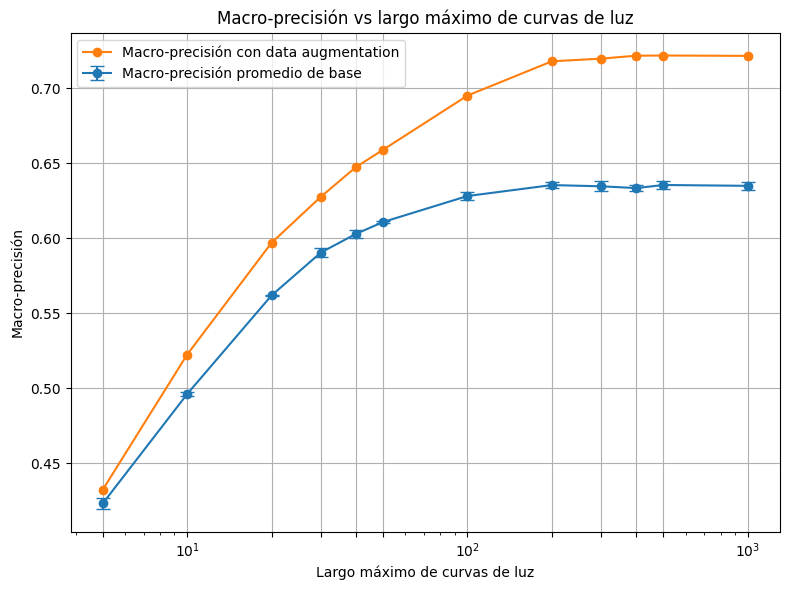

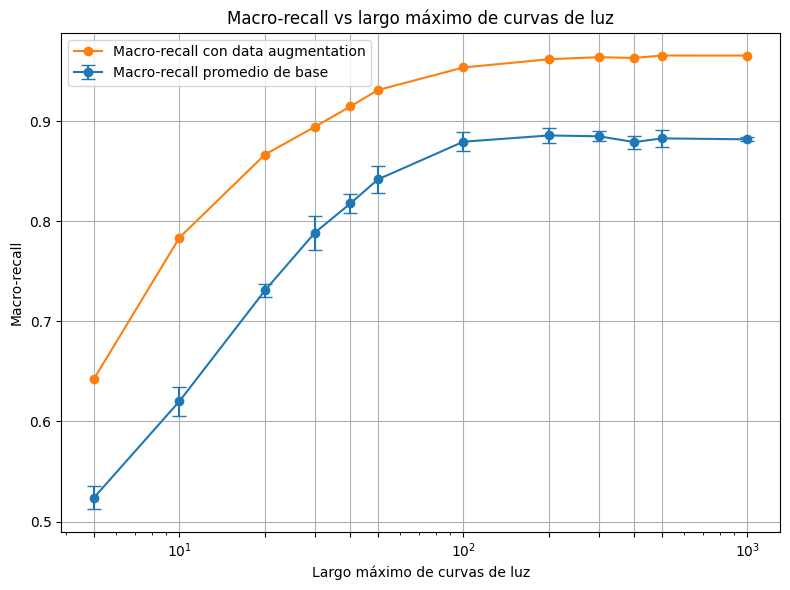

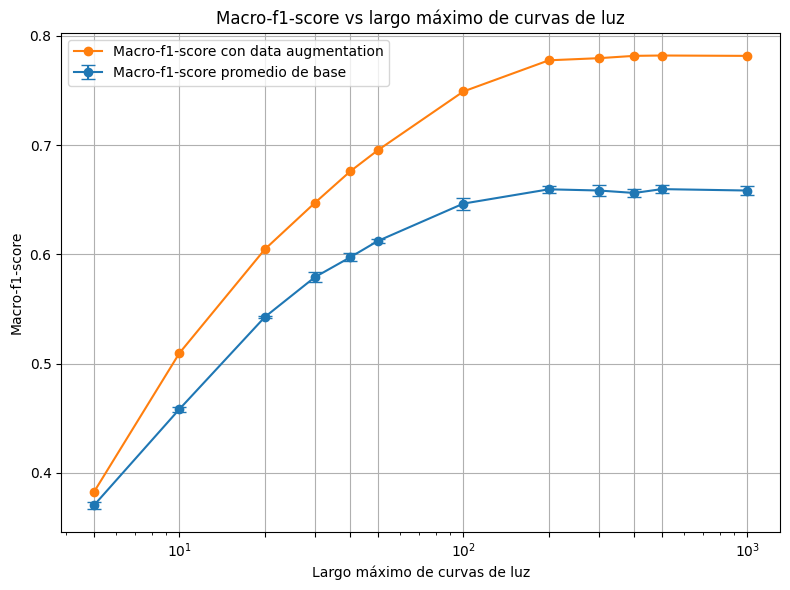

In [ ]:
import matplotlib.pyplot as plt

macro_precision_list = macro_metrics2.loc['precision']['macro avg']
macro_recall_list = macro_metrics2.loc['recall']['macro avg']
macro_f1score_list = macro_metrics2.loc['f1-score']['macro avg']

# gráfico de la macro-precisión según el largo máximo de las curvas de luz
plt.figure(figsize=(8, 6))
# gráfico con barras de error para los k-folds
plt.errorbar(n_detecciones, mean_macro_precision_list, yerr=std_macro_precision_list, fmt='o-', capsize=5, label='Macro-precisión promedio de base')
plt.plot(n_detecciones, macro_precision_list, 'o-', label='Macro-precisión con data augmentation')
plt.legend()
plt.xlabel('Largo máximo de curvas de luz')
plt.ylabel('Macro-precisión')
plt.title('Macro-precisión vs largo máximo de curvas de luz')

plt.xscale('log') # escala logarítmica para mejor visualización
plt.grid(True)
plt.xticks(n_detecciones) # puntos de interés del eje x
plt.tight_layout()

plt.show()

# gráfico del macro-recall según el largo máximo de las curvas de luz
plt.figure(figsize=(8, 6))
# gráfico con barras de error para los k-folds
plt.errorbar(n_detecciones, mean_macro_recall_list, yerr=std_macro_recall_list, fmt='o-', capsize=5, label='Macro-recall promedio de base')
plt.plot(n_detecciones, macro_recall_list, 'o-', label='Macro-recall con data augmentation')
plt.legend()
plt.xlabel('Largo máximo de curvas de luz')
plt.ylabel('Macro-recall')
plt.title('Macro-recall vs largo máximo de curvas de luz')

plt.xscale('log') # escala logarítmica para mejor visualización
plt.grid(True)
plt.xticks(n_detecciones) # puntos de interés del eje x
plt.tight_layout()

plt.show()

# gráfico del macro-f1-score según el largo máximo de las curvas de luz
plt.figure(figsize=(8, 6))
# gráfico con barras de error para los k-folds
plt.errorbar(n_detecciones, mean_macro_f1score_list, yerr=std_macro_f1score_list, fmt='o-', capsize=5, label='Macro-f1-score promedio de base')
plt.plot(n_detecciones, macro_f1score_list, 'o-', label='Macro-f1-score con data augmentation')
plt.legend()
plt.xlabel('Largo máximo de curvas de luz')
plt.ylabel('Macro-f1-score')
plt.title('Macro-f1-score vs largo máximo de curvas de luz')

plt.xscale('log') # escala logarítmica para mejor visualización
plt.grid(True)
plt.xticks(n_detecciones) # puntos de interés del eje x
plt.tight_layout()

plt.show()